In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
########### CHANGE

folder_name = './FashionMNIST/gauss VRM std 4.0'
small_folder_names = ['1-x', '1-250', 'x-x+30', 'x-x+60', 'x-250']
data_name = 'FashionMNIST'
perturb_type_param = 'gauss VRM std 4.0'
last = 250
standard_folder_name = './FashionMNIST/standard'
model = 'resnet18_pytorch'

standard_savedir = './standard'
perturb_savedir = './' + perturb_type_param
inner_savedirs = [perturb_savedir + '/start from 1', perturb_savedir + '/window of 30', perturb_savedir + '/window of 60']
inner_inner_dirnames = ['layerwise fisher', 'normalised layerwise fisher']
inner_inner_savedirs = list()
for a in inner_savedirs:
    for b in inner_inner_dirnames:
        inner_inner_savedirs.append(a + '/' + b)

if model == 'resnet18_external':
    idx_layer = np.array([1, 6, 9, 12, 15, 18, 21, 25, 28, 31, 34, 38, 41, 44, 47, 51, 54, 55, 56]) - 1
    numel_layer = np.array([1728, 36864, 36864, 36864, 36864, 73728, 147456, 147456, 147456, 294912, 589824, 589824, 589824, 1179648, 2359296, 2359296, 2359296, 5120, 10])
elif model == 'resnet18_pytorch':
    idx_layer = np.array([1, 4, 7, 10, 13, 16, 19, 25, 28, 31, 34, 40, 43, 46, 49, 55, 57, 61, 62]) - 1
    numel_layer = np.array([3136, 36864, 36864, 36864, 36864, 73728, 147456, 147456, 147456, 294912, 589824, 589824, 589824, 1179648, 2359296, 2359296, 2359296, 5120, 10])

In [3]:
print(standard_savedir)
print(perturb_savedir)
print(inner_savedirs)
print(inner_inner_savedirs)

./standard
./gauss VRM std 4.0
['./gauss VRM std 4.0/start from 1', './gauss VRM std 4.0/window of 30', './gauss VRM std 4.0/window of 60']
['./gauss VRM std 4.0/start from 1/layerwise fisher', './gauss VRM std 4.0/start from 1/normalised layerwise fisher', './gauss VRM std 4.0/window of 30/layerwise fisher', './gauss VRM std 4.0/window of 30/normalised layerwise fisher', './gauss VRM std 4.0/window of 60/layerwise fisher', './gauss VRM std 4.0/window of 60/normalised layerwise fisher']


In [4]:
def make_dir(dir_str):
    if not os.path.exists(dir_str):
        os.mkdir(dir_str)

In [5]:
make_dir(standard_savedir)
make_dir(perturb_savedir)
for a in inner_savedirs:
    make_dir(a)
for a in inner_inner_savedirs:
    make_dir(a)

In [6]:
def load_history(filename_dir):
    with open(filename_dir, 'r') as fp:
        history = json.load(fp)
    return history

In [7]:
def get_CLP_content(folder_name, small_folder_name, file_name):
    f = open(folder_name + '/' + small_folder_name + '/' + file_name, 'r')
    return f.read()

In [8]:
def return_correct_CLP_filename(target, folder_name, small_folder_name, CLP_files):
    for CLP_file in CLP_files:
        CLPgot = get_CLP_content(folder_name, small_folder_name, CLP_file)
        if CLPgot == target:
            return CLP_file
    return None

In [9]:
def get_histories(CLPs, folder_name, small_folder_name):
    histories = list()
    listdir = os.listdir(folder_name + '/' + small_folder_name)
    if CLPs[0] is not None:
        CLP_files = [name for name in listdir if name.endswith('.txt')]
        for i in range(len(CLPs)):
            correct_CLP_filename = return_correct_CLP_filename(str(CLPs[i]), folder_name, small_folder_name, CLP_files)
            correct_json_filename = [name for name in listdir if name.endswith(correct_CLP_filename.split('.')[0] + '.json')][0]
            history = load_history(folder_name + '/' + small_folder_name + '/' + correct_json_filename)
            histories.append(history)
        return histories
    else:
        correct_json_filename = [name for name in listdir if name.endswith('.json')][0]
        history = load_history(folder_name + '/' + small_folder_name + '/' + correct_json_filename)
        histories.append(history)
        return histories

In [10]:
def plot_accuracy(histories, denote, data_name, perturb_type_param, standard_history, last, save_dir, filename):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    legends = ['[{}, {}]'.format(y[0], y[1]) for y in denote]
    title_fontsize = 17
    other_fontsize = 15
    legend_fontsize = 13
    plt.figure(figsize=(19, 11))
    for i in range(len(denote)):
        plt.plot(np.arange(last) + 1, histories[i]['epoch_train_accuracy'], colours[i] + '-.', label=legends[i] + ' train', linewidth=1.35)
        plt.plot(np.arange(last) + 1, histories[i]['epoch_test_accuracy'], colours[i] + '-', label=legends[i] + ' test', linewidth=1.35)
    plt.plot(np.arange(last) + 1, standard_history['epoch_train_accuracy'], colours[-1] + '-.', label='standard' + ' train', linewidth=1.35)
    plt.plot(np.arange(last) + 1, standard_history['epoch_test_accuracy'], colours[-1] + '-', label='standard' + ' test', linewidth=1.35)
    plt.xlabel('Epoch', fontsize=other_fontsize)
    plt.ylabel('Accuracy', fontsize=other_fontsize)
    plt.title('{} {} Train/Test Accuracy\nPerturb/Deficit period: [$start$, $end$]'.format(data_name, perturb_type_param), fontsize=title_fontsize)
    plt.legend(bbox_to_anchor=(1.01,1.016), loc="upper left", fontsize=legend_fontsize)
    plt.grid()
    plt.savefig(save_dir + '/' + filename, bbox_inches = "tight")
    plt.show()

In [11]:
def plot_loss(histories, denote, data_name, perturb_type_param, standard_history, last, save_dir, filename):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    legends = ['[{}, {}]'.format(y[0], y[1]) for y in denote]
    title_fontsize = 17
    other_fontsize = 15
    legend_fontsize = 13
    plt.figure(figsize=(19, 11))
    for i in range(len(denote)):
        plt.plot(np.arange(last) + 1, histories[i]['epoch_mean_train_loss'], colours[i] + '-.', label=legends[i] + ' train', linewidth=1.35)
        plt.plot(np.arange(last) + 1, histories[i]['epoch_mean_test_loss'], colours[i] + '-', label=legends[i] + ' test', linewidth=1.35)
        plt.plot(np.arange(last) + 1, histories[i]['epoch_mean_perturb_loss'], colours[i] + ':', label=legends[i] + ' perturb', linewidth=1.35)
    plt.plot(np.arange(last) + 1, standard_history['epoch_mean_train_loss'], colours[-1] + '-.', label='standard' + ' train', linewidth=1.35)
    plt.plot(np.arange(last) + 1, standard_history['epoch_mean_test_loss'], colours[-1] + '-', label='standard' + ' test', linewidth=1.35)
    plt.xlabel('Epoch', fontsize=other_fontsize)
    plt.ylabel('Loss', fontsize=other_fontsize)
    plt.title('{} {} Train/Test Loss\nPerturb/Deficit period: [$start$, $end$]'.format(data_name, perturb_type_param), fontsize=title_fontsize)
    plt.legend(bbox_to_anchor=(1.01,1.016), loc="upper left", fontsize=legend_fontsize)
    plt.grid()
    plt.savefig(save_dir + '/' + filename, bbox_inches = "tight")
    plt.show()

In [12]:
def plot_trace_fisher_all(histories, denote, data_name, perturb_type_param, standard_history, last, save_dir, filename):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    legends = ['[{}, {}]'.format(y[0], y[1]) for y in denote]
    title_fontsize = 17
    other_fontsize = 15
    legend_fontsize = 13
    plt.figure(figsize=(19, 11))
    for i in range(len(denote)):
        plt.plot(np.arange(last) + 1, histories[i]['epoch_fisher_trace'], colours[i] + '-', label=legends[i], linewidth=2)
    plt.plot(np.arange(last) + 1, standard_history['epoch_fisher_trace'], colours[-1] + '-', label='standard', linewidth=2)
    plt.xlabel('Epoch', fontsize=other_fontsize)
    plt.ylabel('tr(FIM)', fontsize=other_fontsize)
    plt.title('{} {} Trace of Fisher Information Matrix (entire model)\nPerturb/Deficit period: [$start$, $end$]'.format(data_name, perturb_type_param), fontsize=title_fontsize)
    plt.legend(bbox_to_anchor=(1.01,1.016), loc="upper left", fontsize=legend_fontsize)
    plt.grid()
    plt.savefig(save_dir + '/' + filename, bbox_inches = "tight")
    plt.show()

In [13]:
def plot_layerwise_trace_fisher(history, idx_layer, numel_layer, model, last, mean, data_name, perturb_type_param, subtitle, save_dir, filename):
    temp = np.array(history['epoch_layerwise_fisher_trace']).copy()
    if model == 'resnet18_external':
        temp = temp[:, idx_layer]
        temp[:, 17] = np.sum(temp[:, [17, 18]], axis=1)
        layerwise_fishers = temp[:, :18]
        numel_layer_modified = numel_layer.copy()
        numel_layer_modified[17] = numel_layer_modified[17] + numel_layer_modified[18]
        numel_layer_modified = numel_layer_modified[:18]
    elif model == 'resnet18_pytorch':
        temp = temp[:, idx_layer]
        temp[:, 17] = np.sum(temp[:, [17, 18]], axis=1)
        layerwise_fishers = temp[:, :18]
        numel_layer_modified = numel_layer.copy()
        numel_layer_modified[17] = numel_layer_modified[17] + numel_layer_modified[18]
        numel_layer_modified = numel_layer_modified[:18]
    
    if mean:
        if model == 'resnet18_external':
            layerwise_fishers = layerwise_fishers / numel_layer_modified.reshape(1, 18)
        elif model == 'resnet18_pytorch':
            layerwise_fishers = layerwise_fishers / numel_layer_modified.reshape(1, 18)
    
    title_fontsize = 17
    other_fontsize = 15
    legend_fontsize = 13
    plt.figure(figsize=(19, 11))
    colours = plt.cm.jet(np.linspace(0, 1, layerwise_fishers.shape[1]))
    for i in range(layerwise_fishers.shape[1]):
        plt.plot(np.arange(last) + 1, layerwise_fishers[:, i], color=colours[i], label='layer {}'.format(i + 1), linewidth=2)
    plt.xlabel('Epoch', fontsize=other_fontsize)
    plt.ylabel('tr(FIM_layerwise)', fontsize=other_fontsize)
    plt.title('{} {} Trace of Fisher Information Matrix (layerwise)\n{}'.format(data_name, perturb_type_param, subtitle), fontsize=title_fontsize)
    plt.legend(bbox_to_anchor=(1.01,1.016), loc="upper left", fontsize=legend_fontsize)
    plt.grid()
    plt.savefig(save_dir + '/' + filename, bbox_inches = "tight")
    plt.show()

In [14]:
def plot_final_performance(histories, data_name, perturb_type_param, standard_history, xticks, include_last, save_dir, filename):
    final_train_acc = list()
    final_test_acc = list()
    final_train_acc.append(standard_history['epoch_train_accuracy'][-1])
    final_test_acc.append(standard_history['epoch_test_accuracy'][-1])
    
    if include_last == False:
        histories = histories[:-1]
        xticks = xticks[:-1]
    
    for history in histories:
        final_train_acc.append(history['epoch_train_accuracy'][-1])
        final_test_acc.append(history['epoch_test_accuracy'][-1])
    
    title_fontsize = 17
    other_fontsize = 15
    legend_fontsize = 13
    plt.figure(figsize=(14, 8))
    plt.plot(final_train_acc, 'o-', label='Train', linewidth=1.35)
    plt.plot(final_test_acc, 'o-', label='Test', linewidth=1.35)
    plt.xlabel('Perturb/Deficit Period', fontsize=other_fontsize)
    plt.xticks(np.arange(len(xticks)), xticks, fontsize=legend_fontsize)
    plt.ylabel('Accuracy', fontsize=other_fontsize)
    plt.title('{} {} Train/Test Final Accuracy\nPerturb/Deficit period: [$start$, $end$]'.format(data_name, perturb_type_param), fontsize=title_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.grid()
    plt.savefig(save_dir + '/' + filename, bbox_inches = "tight")
    plt.show()

In [15]:
def plot_sensitive_performance(histories, data_name, perturb_type_param, standard_history, xticks, include_last, save_dir, filename):
    final_train_acc = list()
    final_test_acc = list()
    final_train_acc.append(standard_history['epoch_train_accuracy'][-1])
    final_test_acc.append(standard_history['epoch_test_accuracy'][-1])
    
    if include_last == False:
        histories = histories[:-1]
        xticks = xticks[:-1]
    
    for history in histories:
        final_train_acc.append(history['epoch_train_accuracy'][-1])
        final_test_acc.append(history['epoch_test_accuracy'][-1])
    
    title_fontsize = 17
    other_fontsize = 15
    legend_fontsize = 13
    plt.figure(figsize=(14, 8))
    plt.plot(np.abs(final_train_acc[0] - np.array(final_train_acc)), 'o-', label='Train', linewidth=1.35)
    plt.plot(np.abs(final_test_acc[0] - np.array(final_test_acc)), 'o-', label='Test', linewidth=1.35)
    plt.xlabel('Perturb/Deficit Period', fontsize=other_fontsize)
    plt.xticks(np.arange(len(xticks)), xticks, fontsize=legend_fontsize)
    plt.ylabel('$|Acc-Acc_{{standard}}|$', fontsize=other_fontsize)
    plt.title('{} {} Train/Test Sensitivity $|Acc-Acc_{{standard}}|$\nPerturb/Deficit period: [$start$, $end$]'.format(data_name, perturb_type_param), fontsize=title_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.grid()
    plt.savefig(save_dir + '/' + filename, bbox_inches = "tight")
    plt.show()

In [16]:
def plot_trace_fisher_standard(standard_history, data_name, last, save_dir, filename):
    title_fontsize = 17
    other_fontsize = 15
    legend_fontsize = 13
    plt.figure(figsize=(14, 8))
    plt.plot(np.arange(last) + 1, standard_history['epoch_fisher_trace'], 'k' + '-', label='standard', linewidth=2)
    plt.xlabel('Epoch', fontsize=other_fontsize)
    plt.ylabel('tr(FIM)', fontsize=other_fontsize)
    plt.title('{} {} Trace of Fisher Information Matrix (entire model)\nPerturb/Deficit period: N/A (Standard)'.format(data_name, 'standard'), fontsize=title_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.grid()
    plt.savefig(save_dir + '/' + filename, bbox_inches = "tight")
    plt.show()

# standard

In [17]:
standard_history = load_history(standard_folder_name + '/' + [name for name in os.listdir(standard_folder_name) if name.endswith('.json')][0])

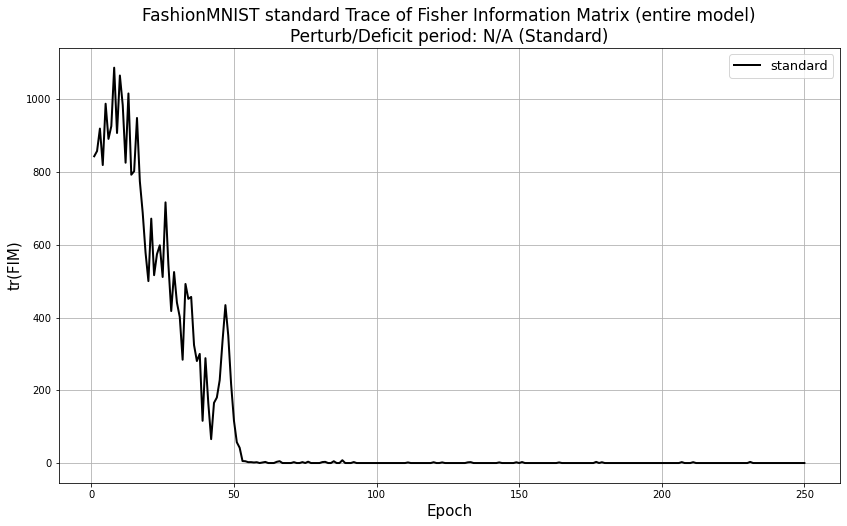

In [18]:
plot_trace_fisher_standard(standard_history, data_name, last, standard_savedir, 'total fisher')

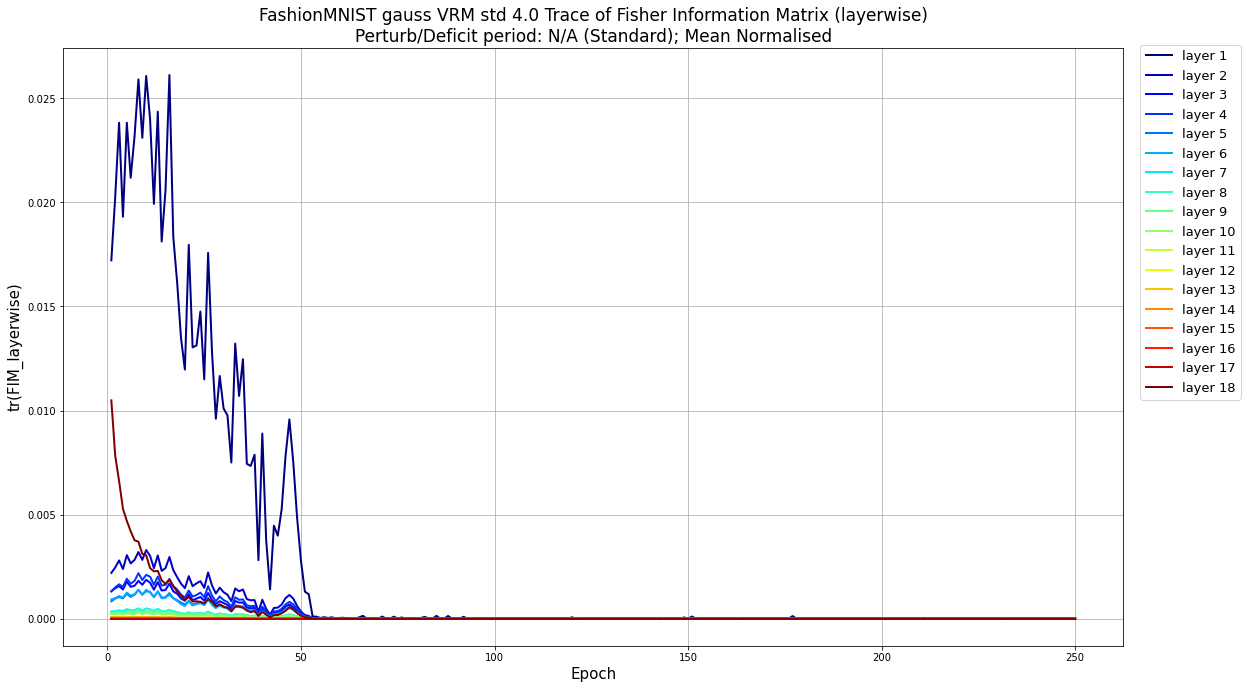

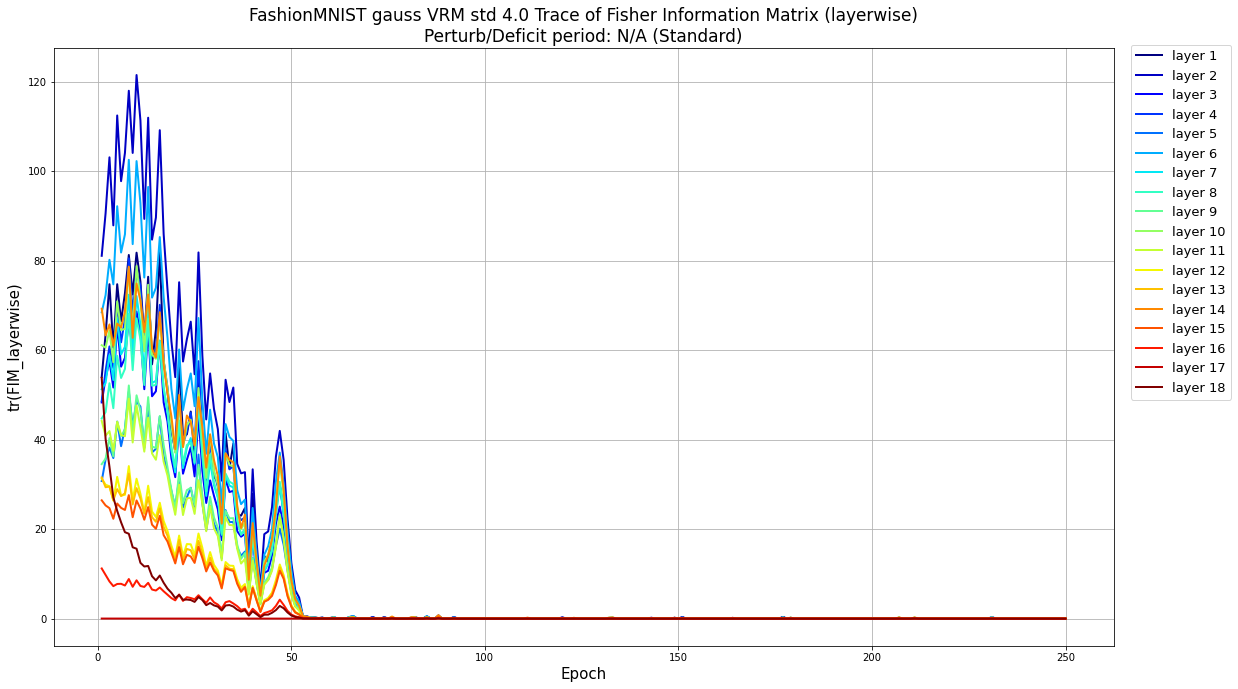

In [19]:
subtitle = 'Perturb/Deficit period: N/A (Standard); Mean Normalised'
plot_layerwise_trace_fisher(standard_history, idx_layer, numel_layer, model, last, True, data_name, perturb_type_param, subtitle, standard_savedir, 'normalised layerwise fisher')
subtitle = 'Perturb/Deficit period: N/A (Standard)'
plot_layerwise_trace_fisher(standard_history, idx_layer, numel_layer, model, last, False, data_name, perturb_type_param, subtitle, standard_savedir, 'layerwise fisher')

# 1-x & 1-250

In [20]:
########### CHANGE

CLPs = [
    [(1, 1.0), (21, 0.0)],
    [(1, 1.0), (41, 0.0)],
    [(1, 1.0), (61, 0.0)],
    [(1, 1.0), (81, 0.0)],
    [(1, 1.0), (101, 0.0)],
    None
]
denote = [(1, 20), (1, 40), (1, 60), (1, 80), (1, 100), (1, 250)]
temp1 = get_histories(CLPs[0:5], folder_name, small_folder_names[0])
temp2 = get_histories([CLPs[5]], folder_name, small_folder_names[1])
histories = temp1 + temp2

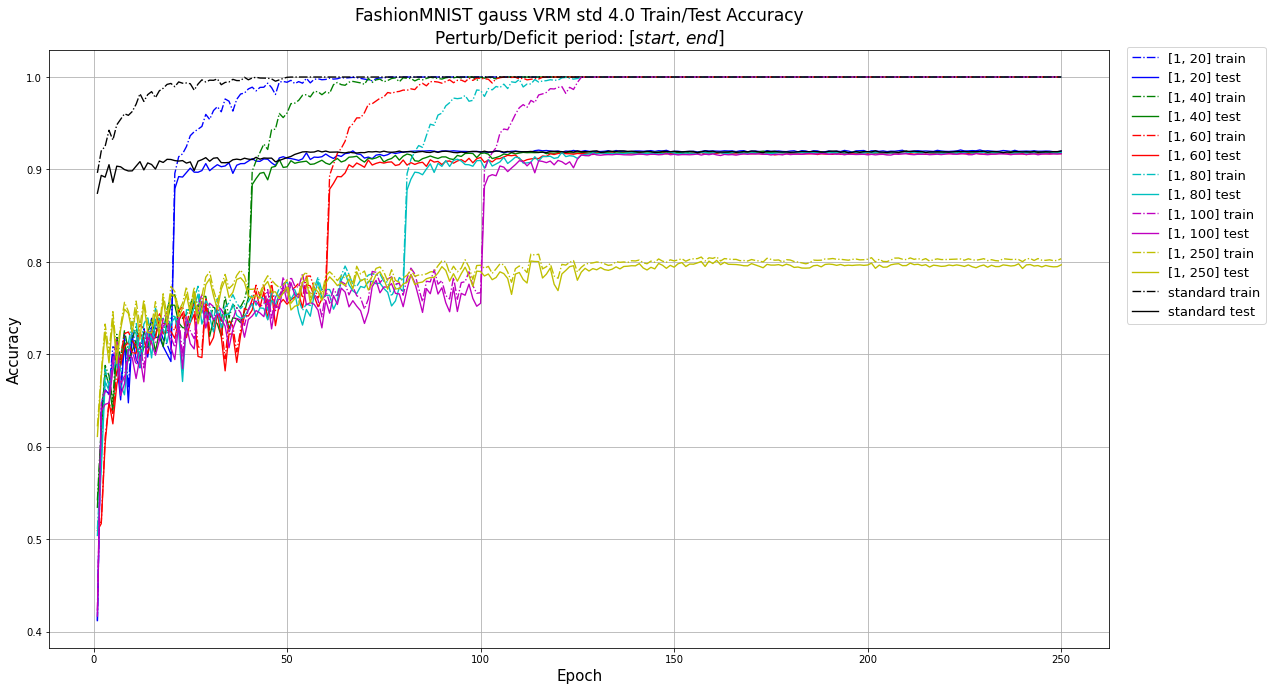

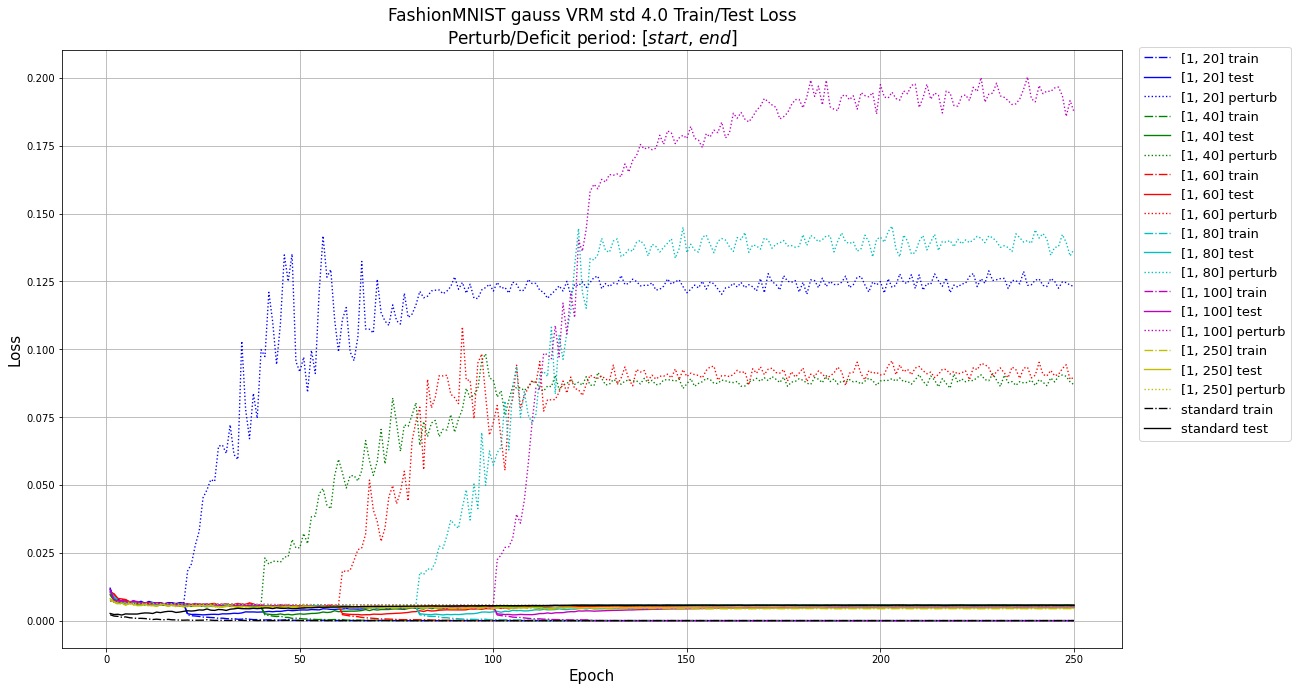

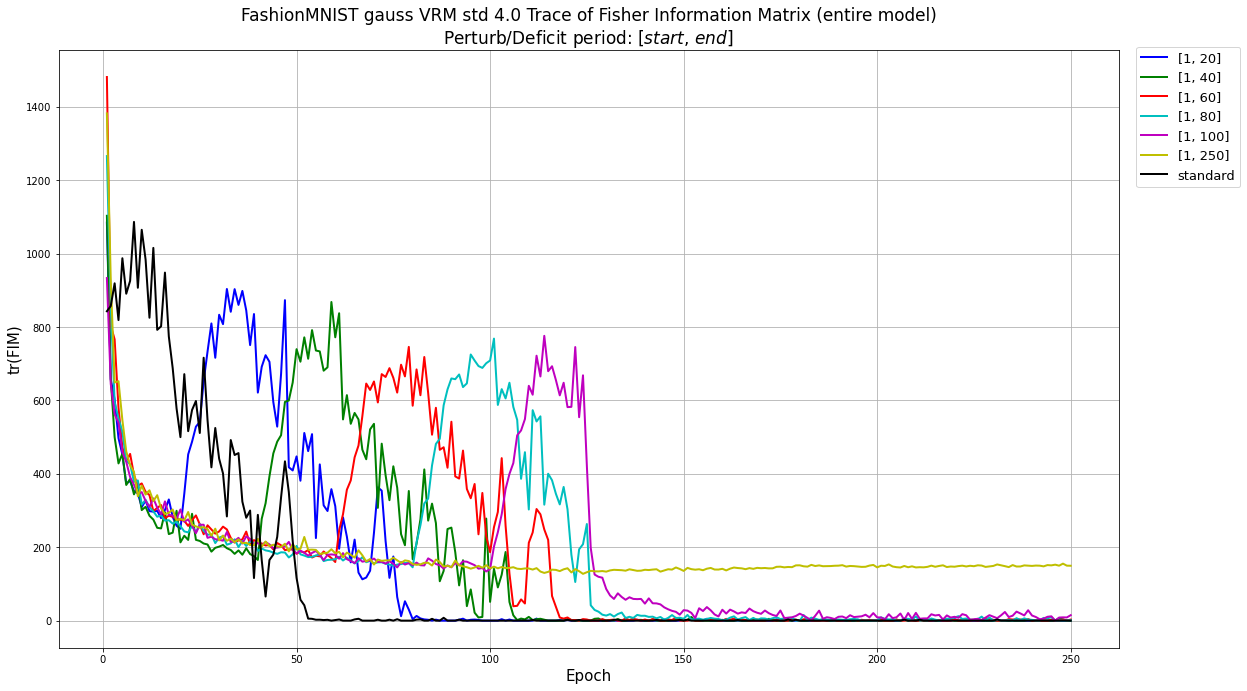

In [21]:
plot_accuracy(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[0], 'accuracy')
plot_loss(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[0], 'loss')
plot_trace_fisher_all(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[0], 'total fisher')

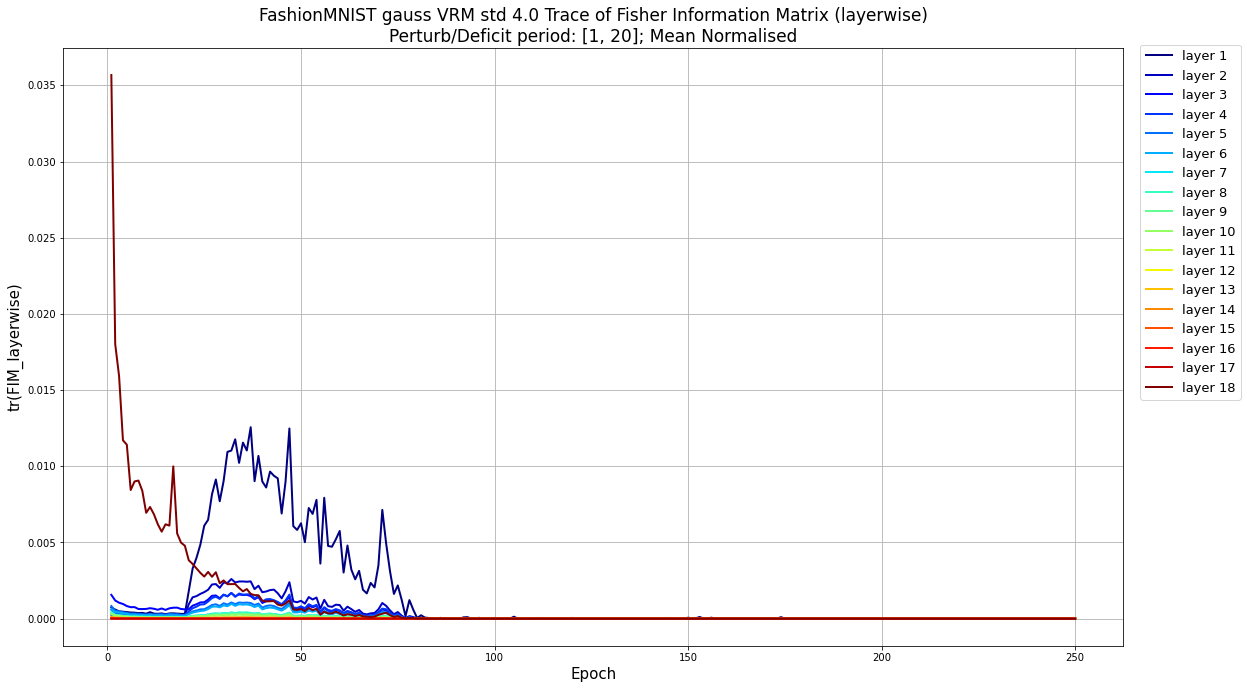

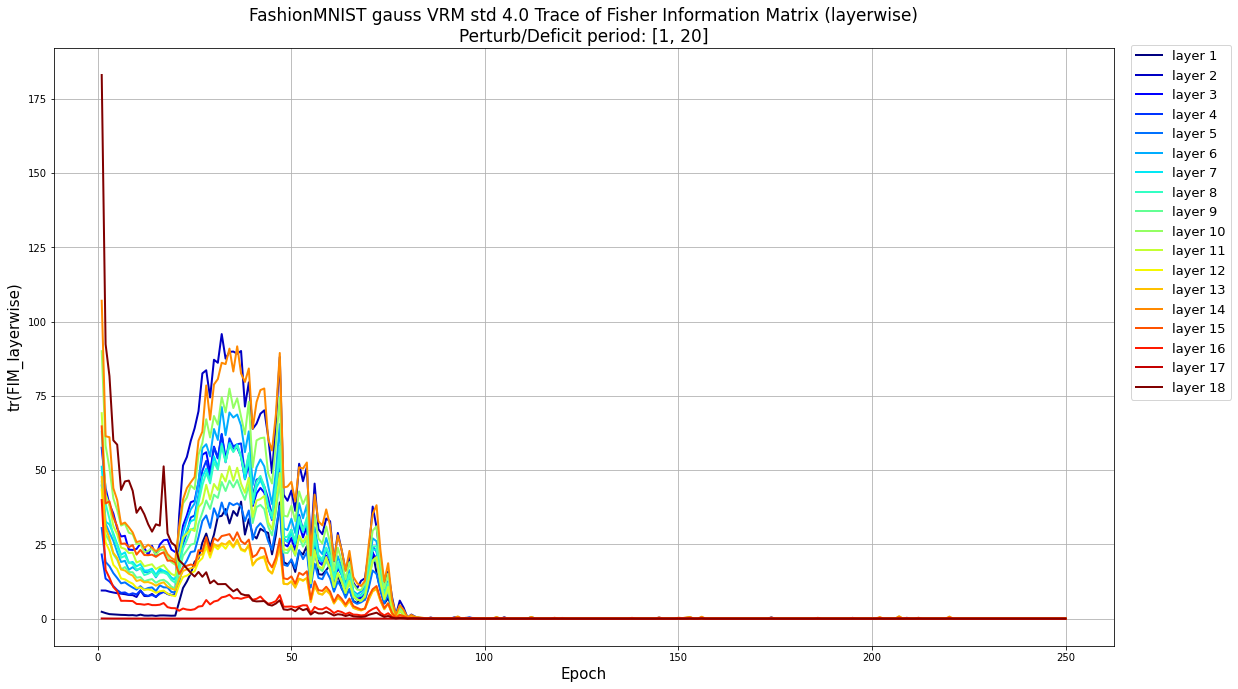

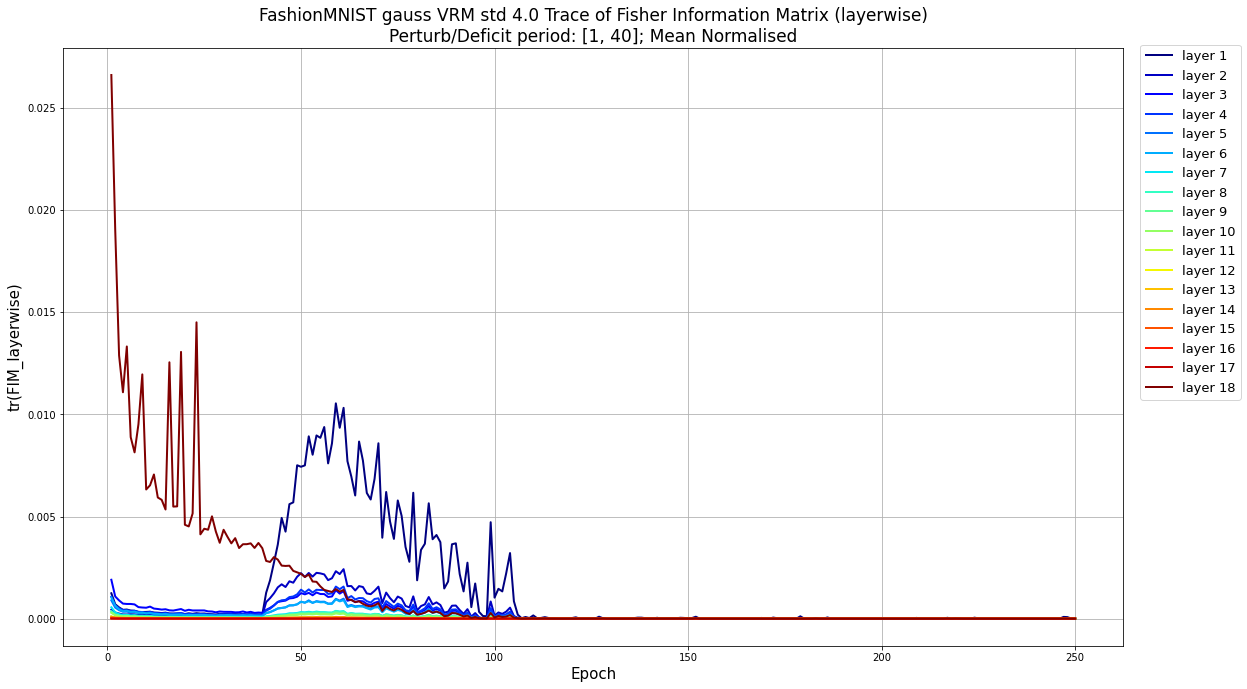

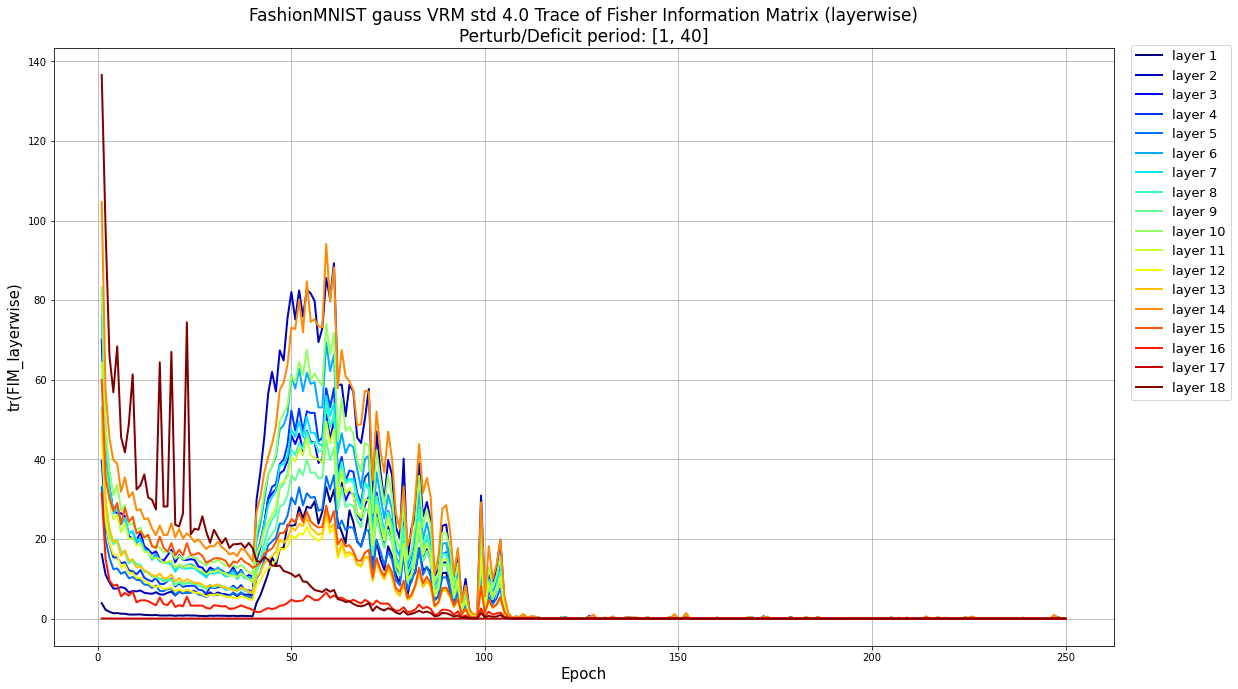

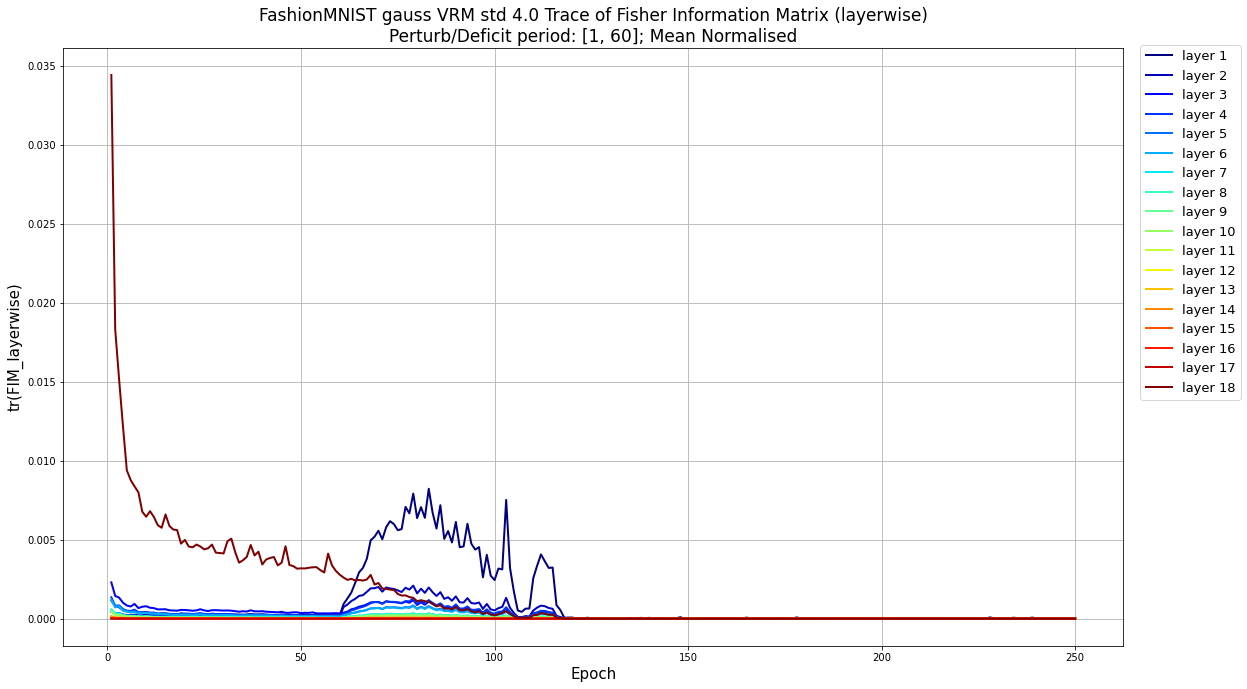

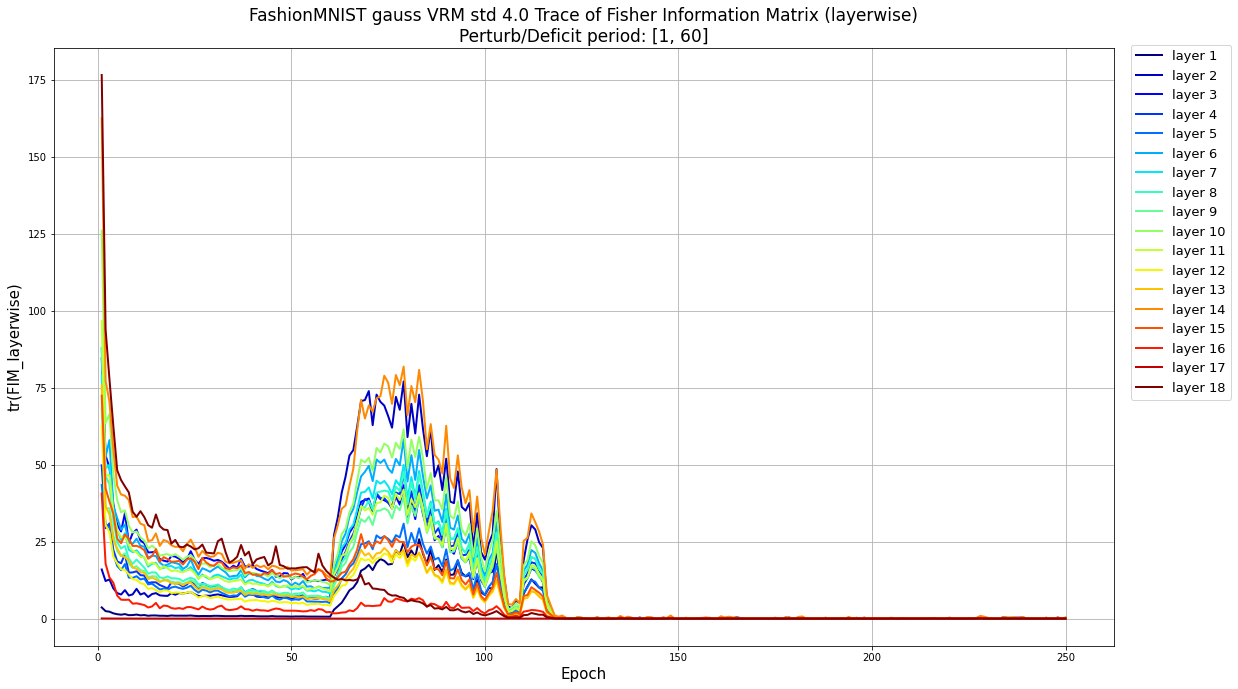

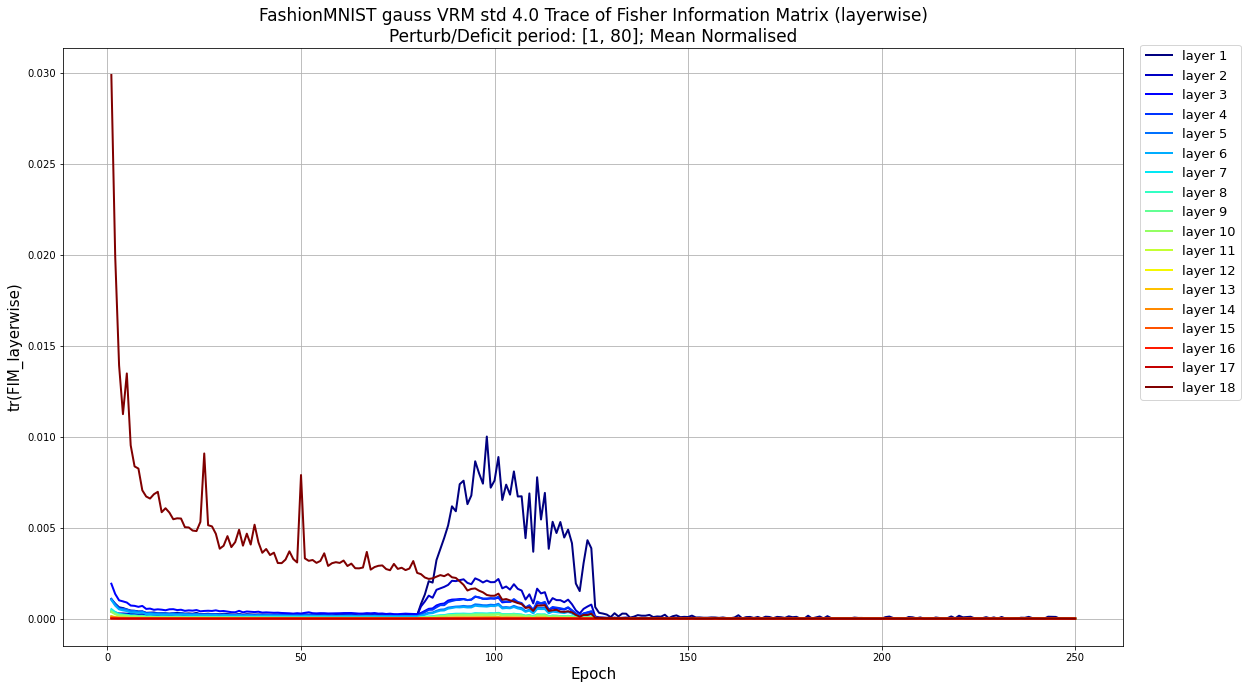

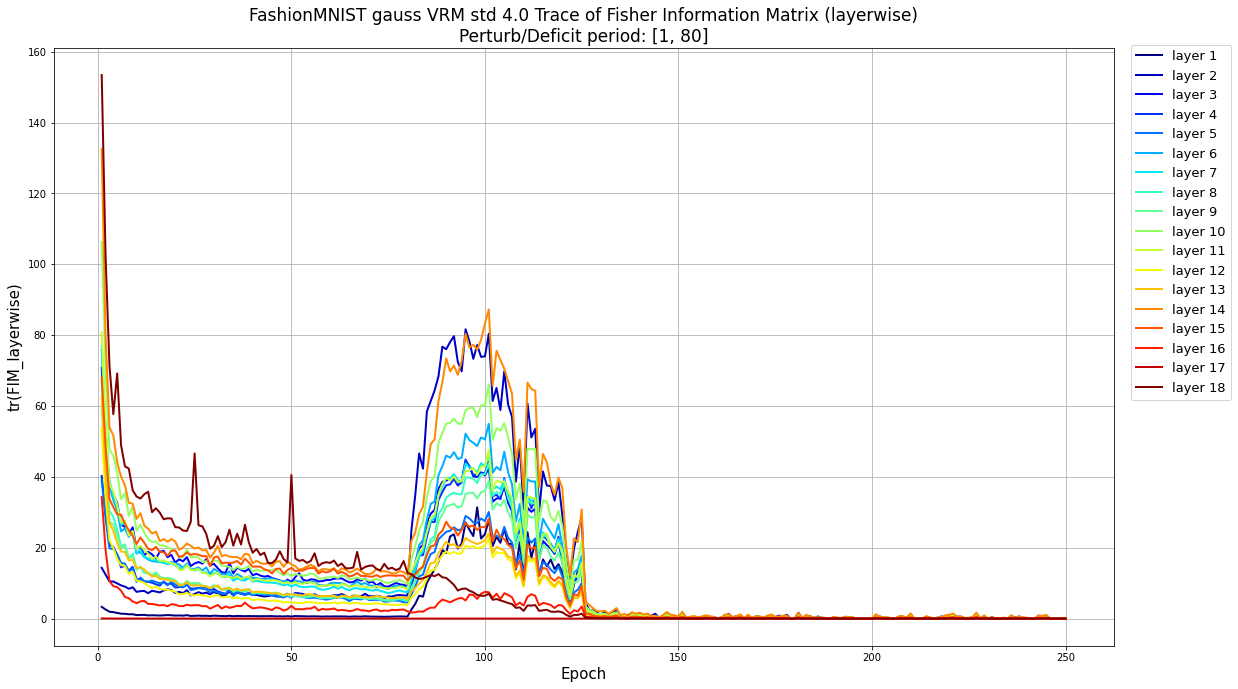

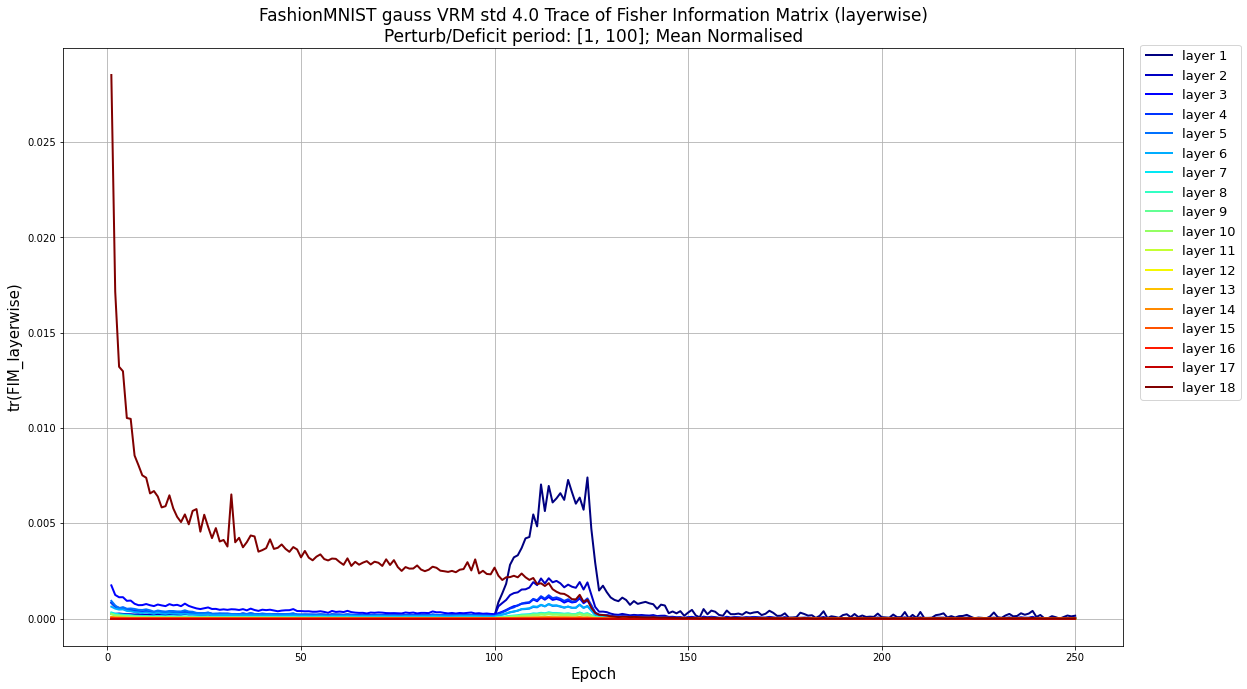

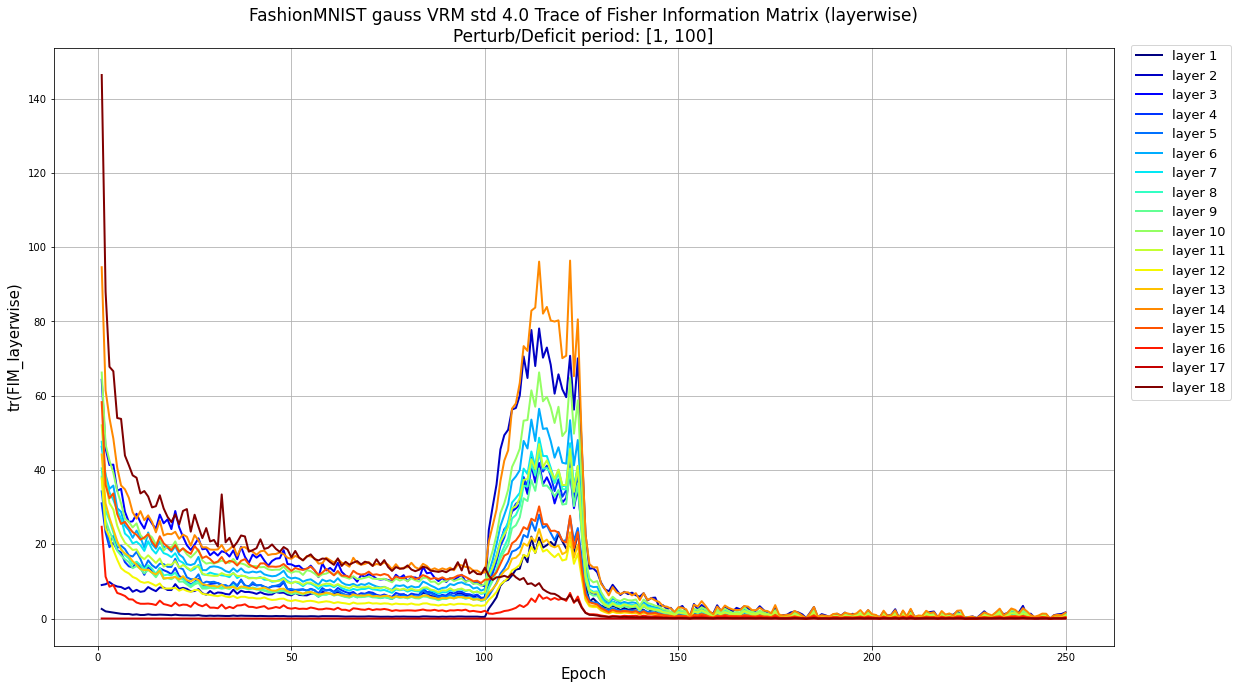

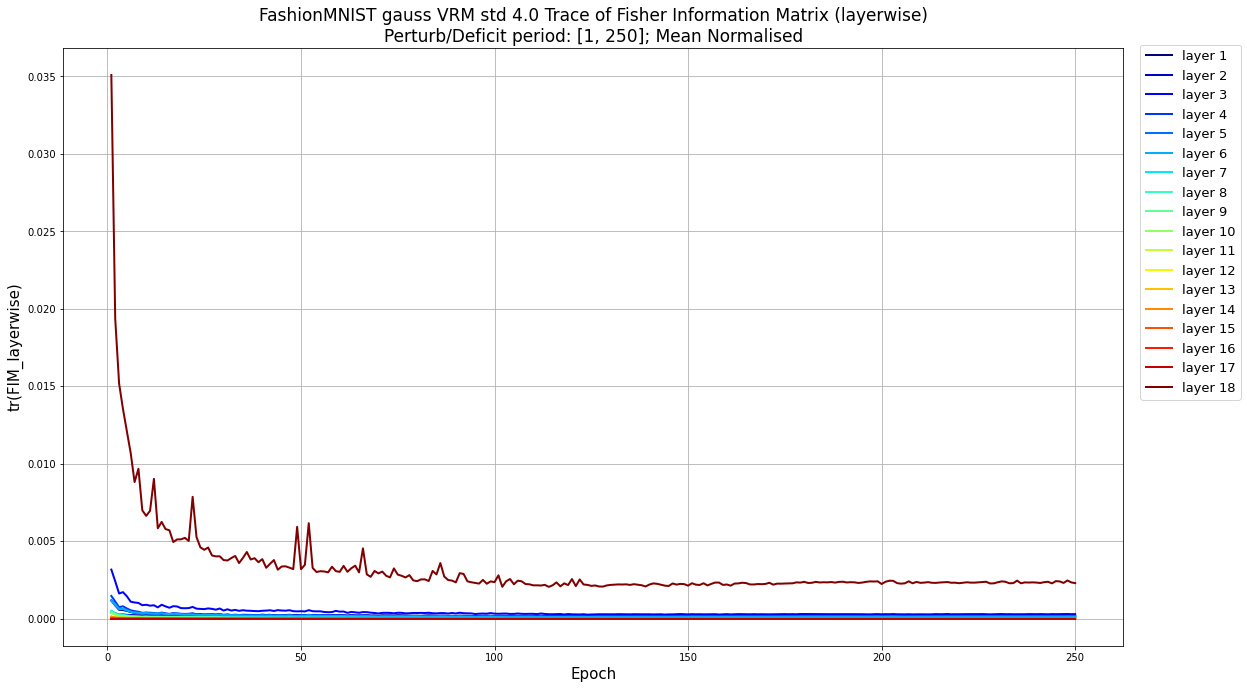

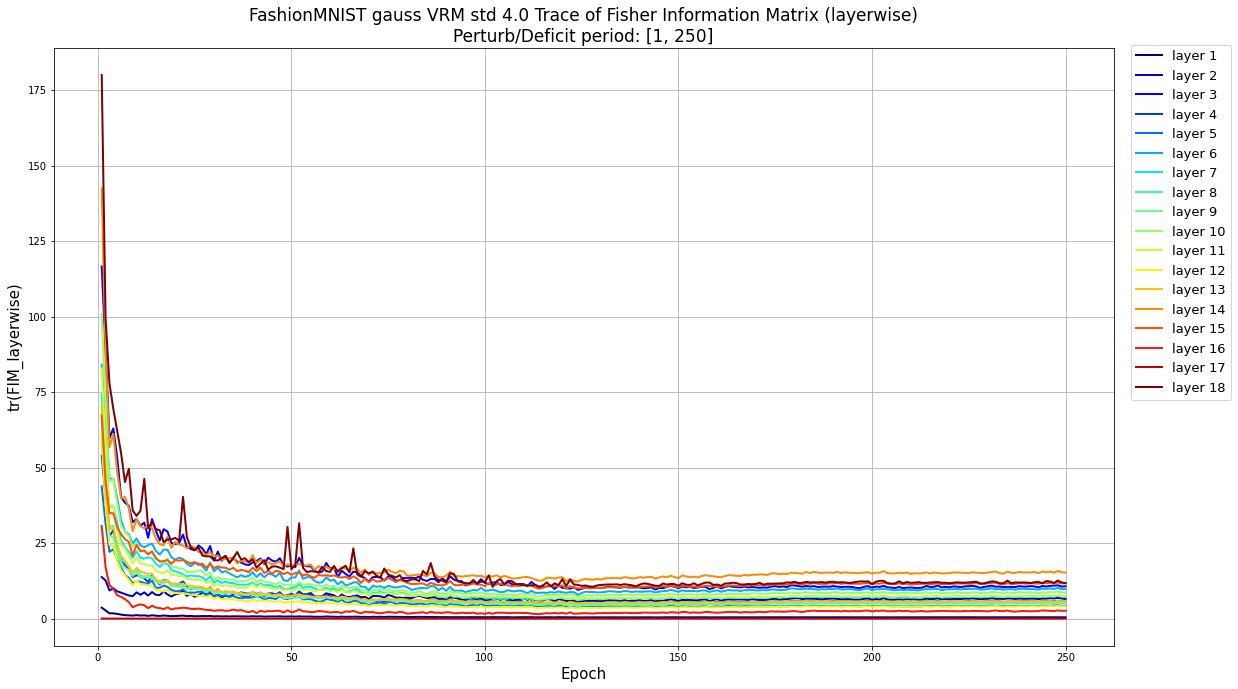

In [22]:
for i, history in enumerate(histories, 0):
    subtitle = 'Perturb/Deficit period: [{}, {}]; Mean Normalised'.format(denote[i][0], denote[i][1])
    plot_layerwise_trace_fisher(history, idx_layer, numel_layer, model, last, True, data_name, perturb_type_param, subtitle, inner_inner_savedirs[1], '{}-{}'.format(denote[i][0], denote[i][1]))
    subtitle = 'Perturb/Deficit period: [{}, {}]'.format(denote[i][0], denote[i][1])
    plot_layerwise_trace_fisher(history, idx_layer, numel_layer, model, last, False, data_name, perturb_type_param, subtitle, inner_inner_savedirs[0], '{}-{}'.format(denote[i][0], denote[i][1]))

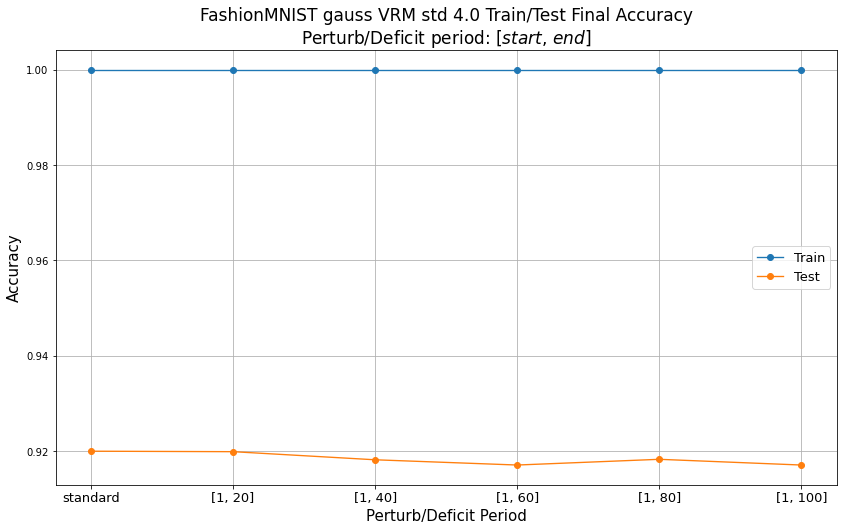

In [23]:
xticks = ['standard'] + ['[{}, {}]'.format(pt[0], pt[1]) for pt in denote]
plot_final_performance(histories, data_name, perturb_type_param, standard_history, xticks, False, inner_savedirs[0], 'final accuracy')

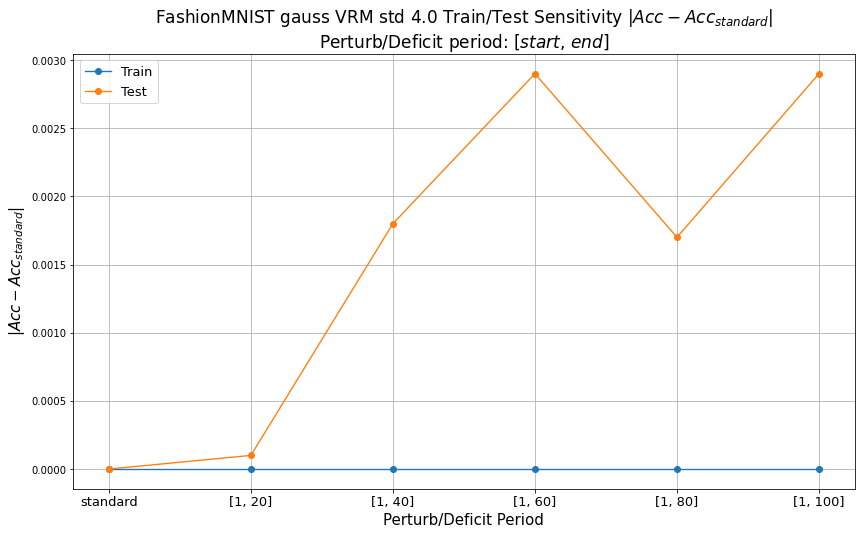

In [24]:
xticks = ['standard'] + ['[{}, {}]'.format(pt[0], pt[1]) for pt in denote]
plot_sensitive_performance(histories, data_name, perturb_type_param, standard_history, xticks, False, inner_savedirs[0], 'sensitivity')

# x-x+30 & 221-250

In [25]:
########### CHANGE

CLPs = [
    [(1, 0.0), (21, 1.0), (51, 0.0)],
    [(1, 0.0), (41, 1.0), (71, 0.0)],
    [(1, 0.0), (61, 1.0), (91, 0.0)],
    [(1, 0.0), (81, 1.0), (111, 0.0)],
    [(1, 0.0), (101, 1.0), (131, 0.0)],
    [(1, 0.0), (221, 1.0)]
]
denote = [(21, 50), (41, 70), (61, 90), (81, 110), (101, 130), (221, 250)]
temp1 = get_histories(CLPs[0:5], folder_name, small_folder_names[2])
temp2 = get_histories([CLPs[5]], folder_name, small_folder_names[4])
histories = temp1 + temp2

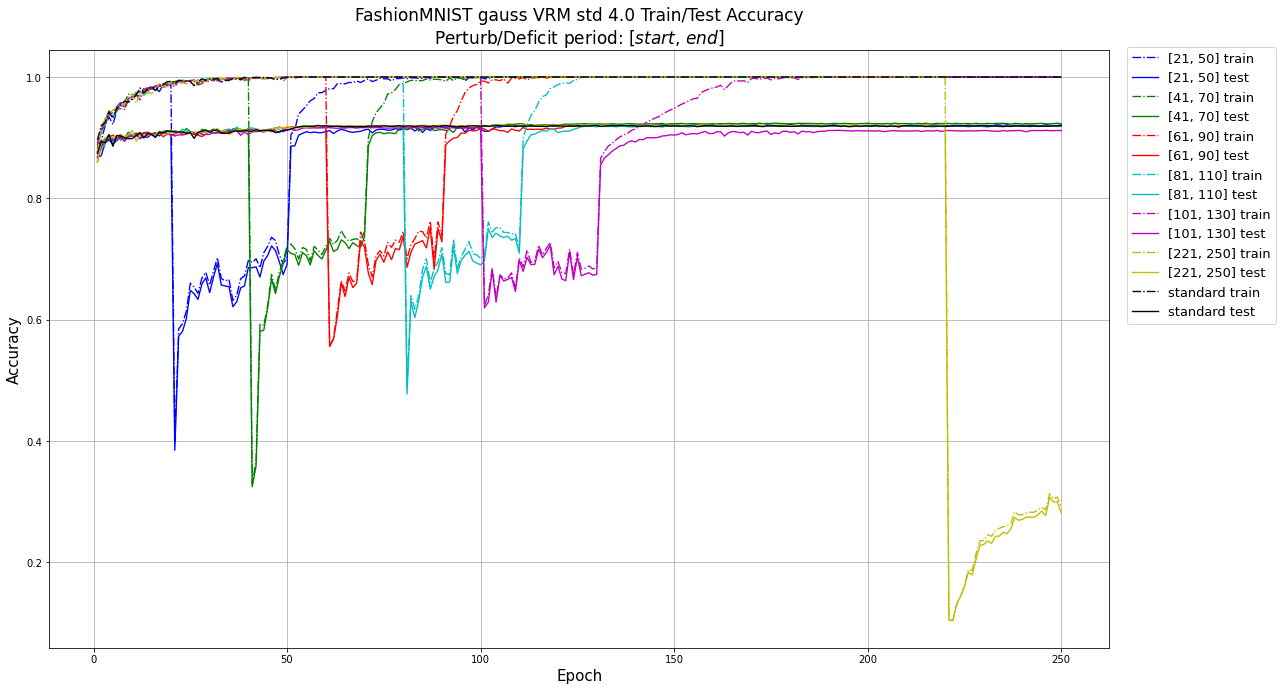

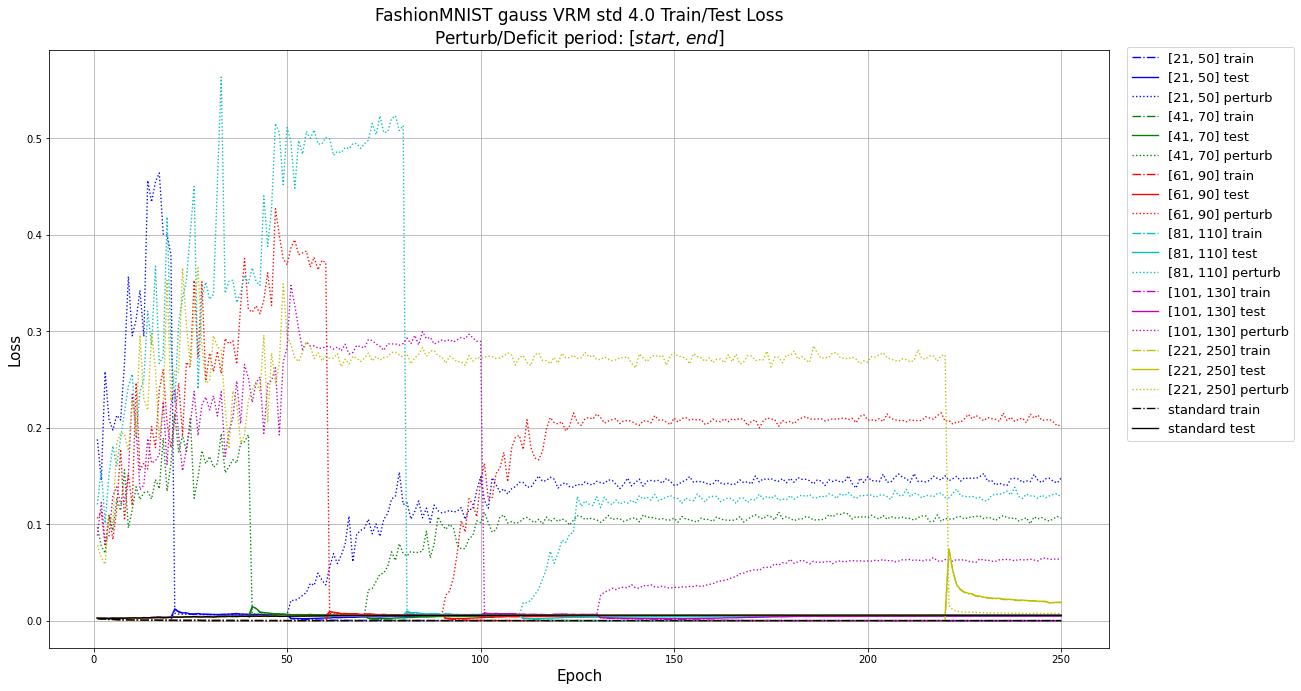

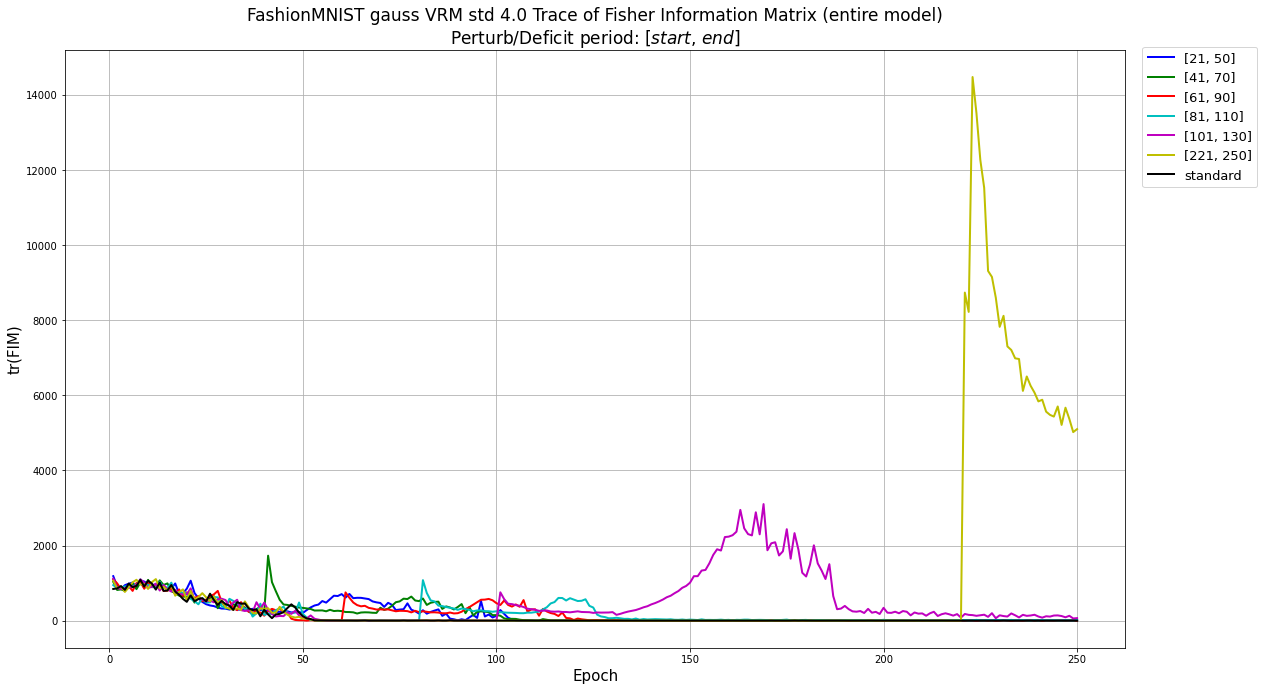

In [26]:
plot_accuracy(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[1], 'accuracy')
plot_loss(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[1], 'loss')
plot_trace_fisher_all(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[1], 'total fisher')

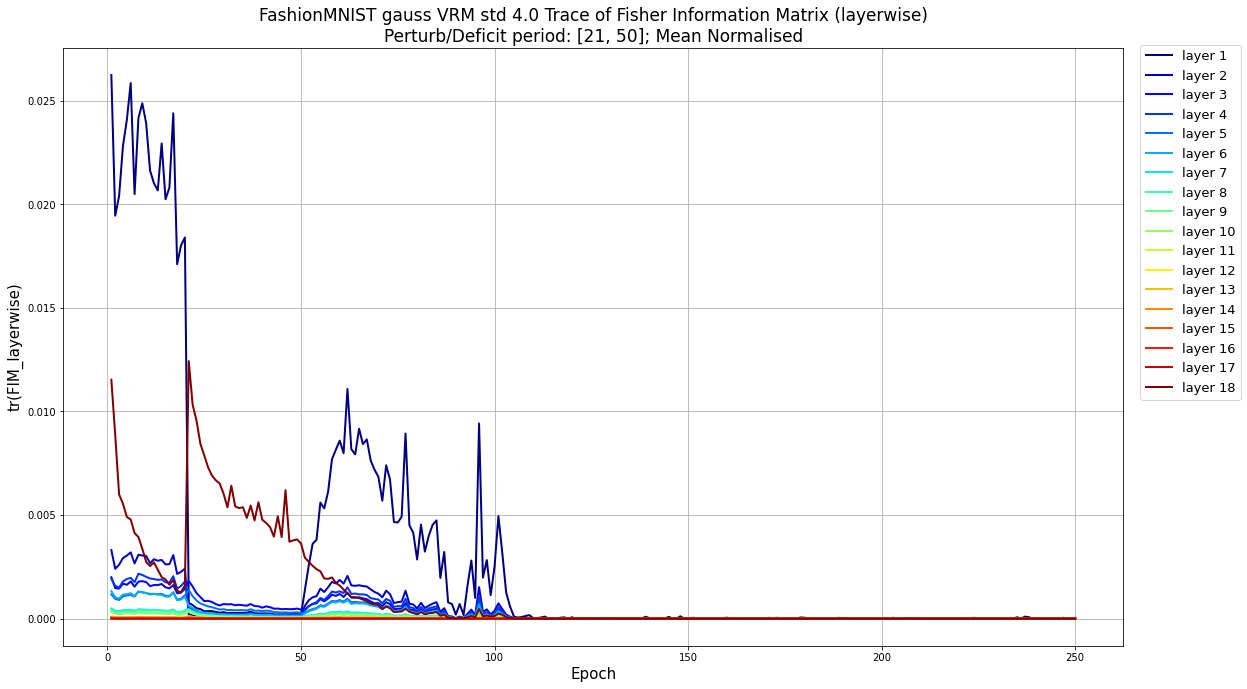

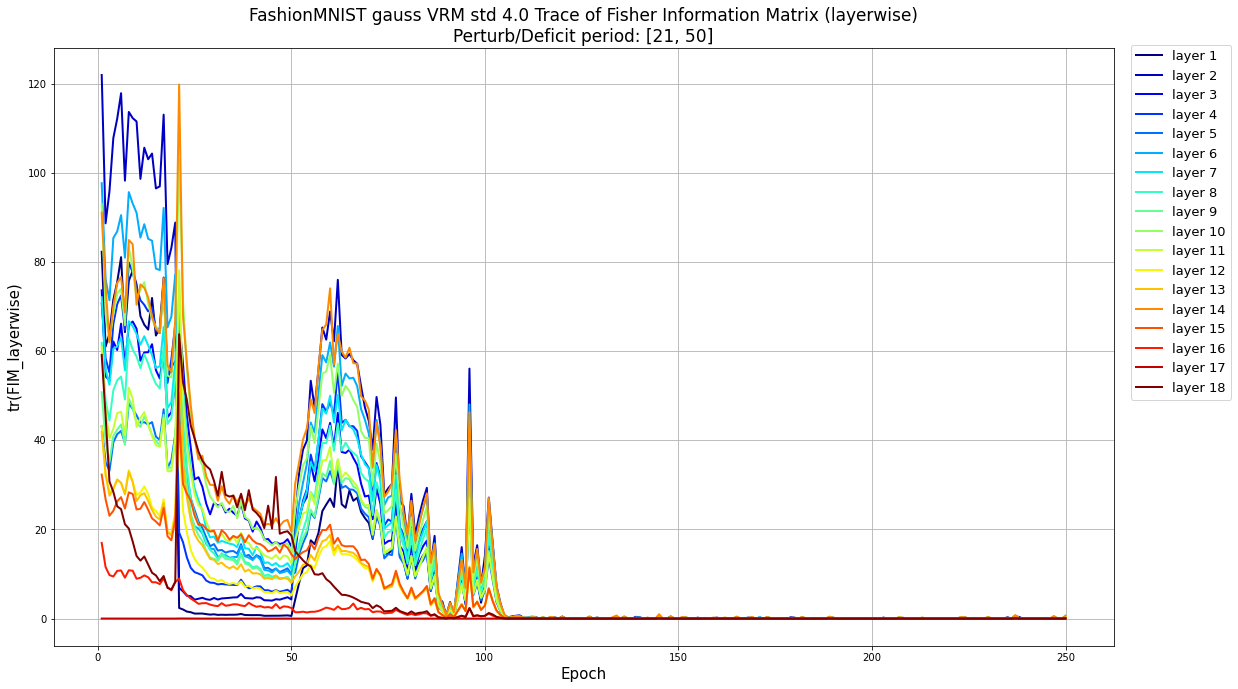

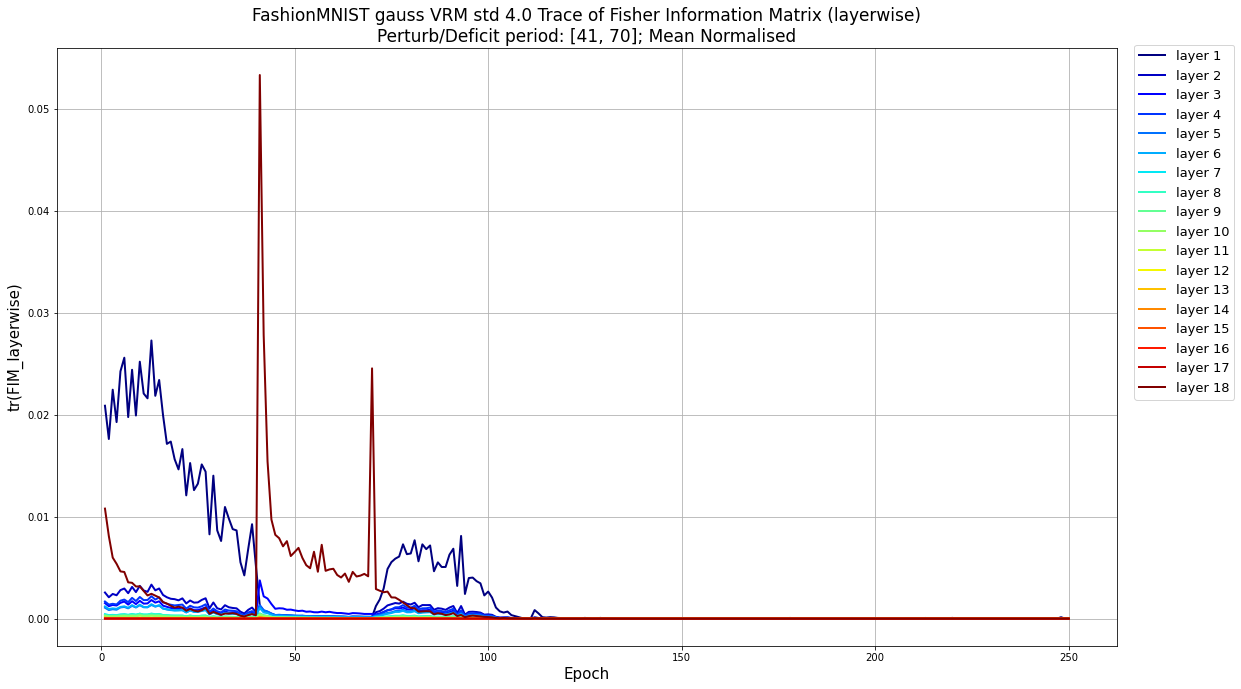

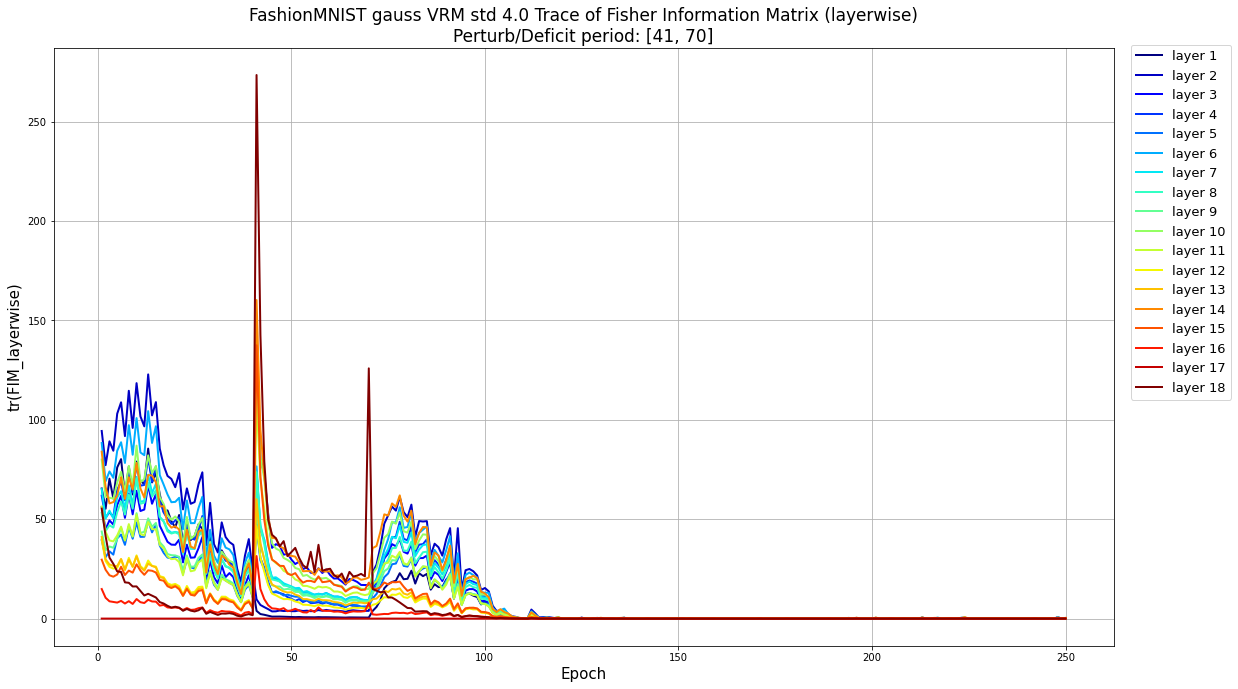

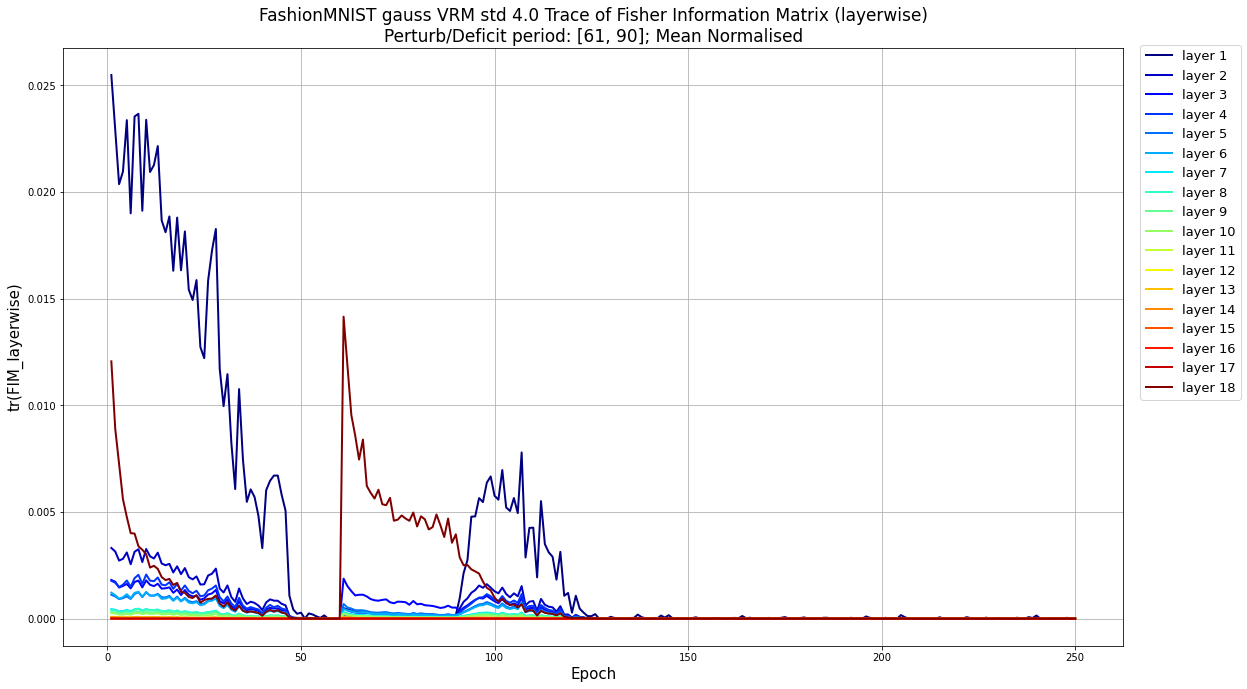

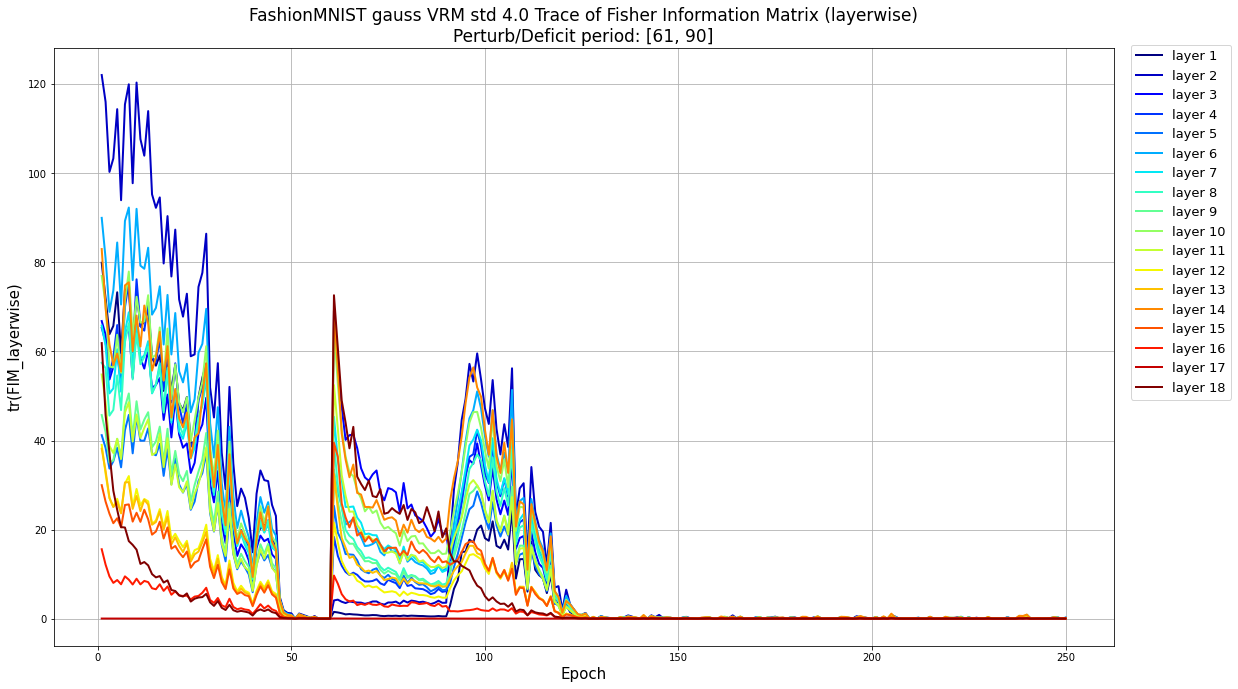

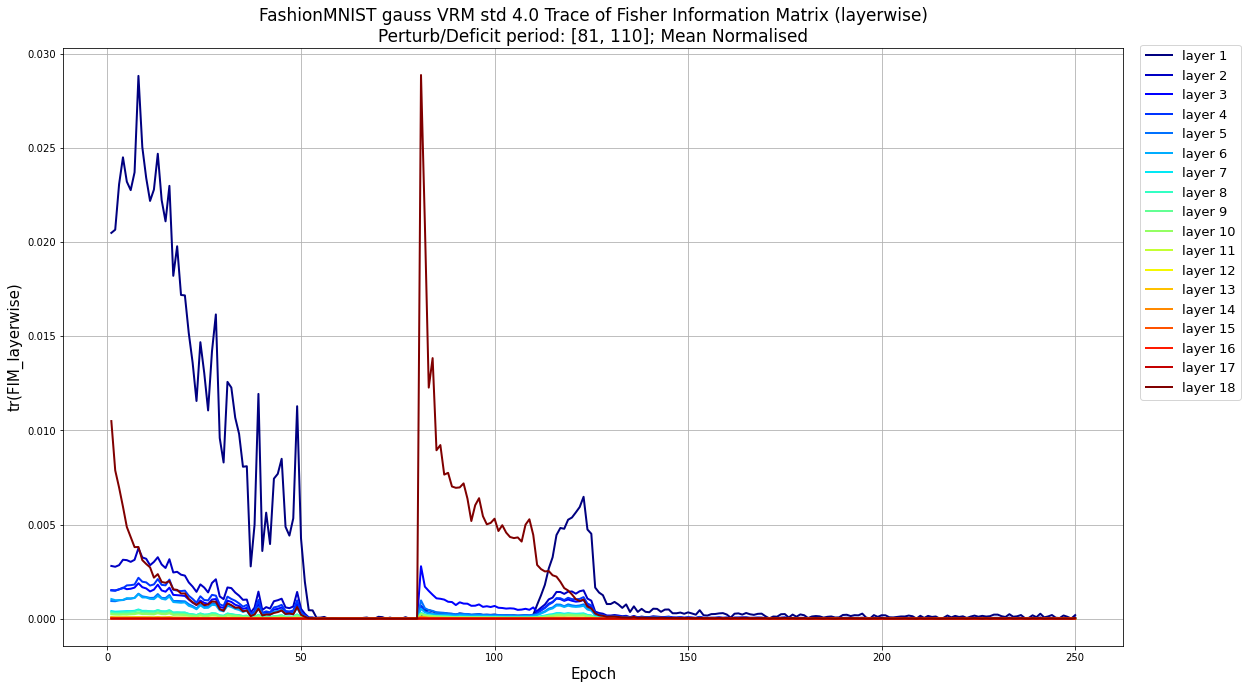

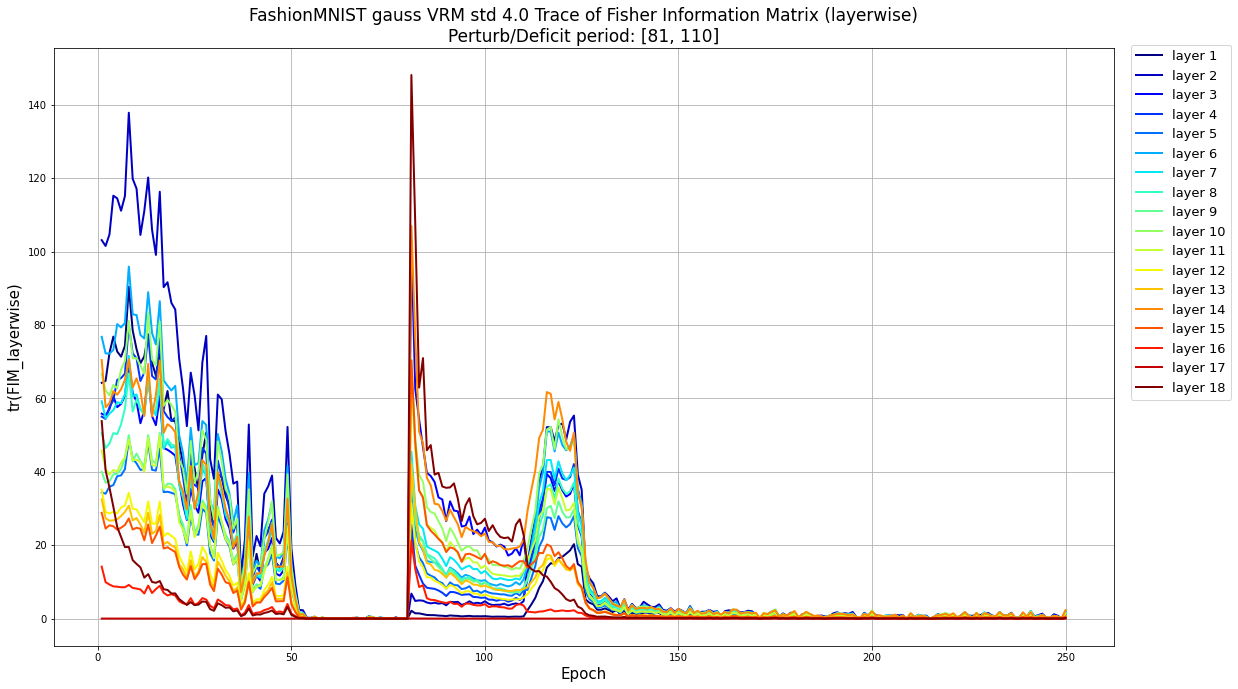

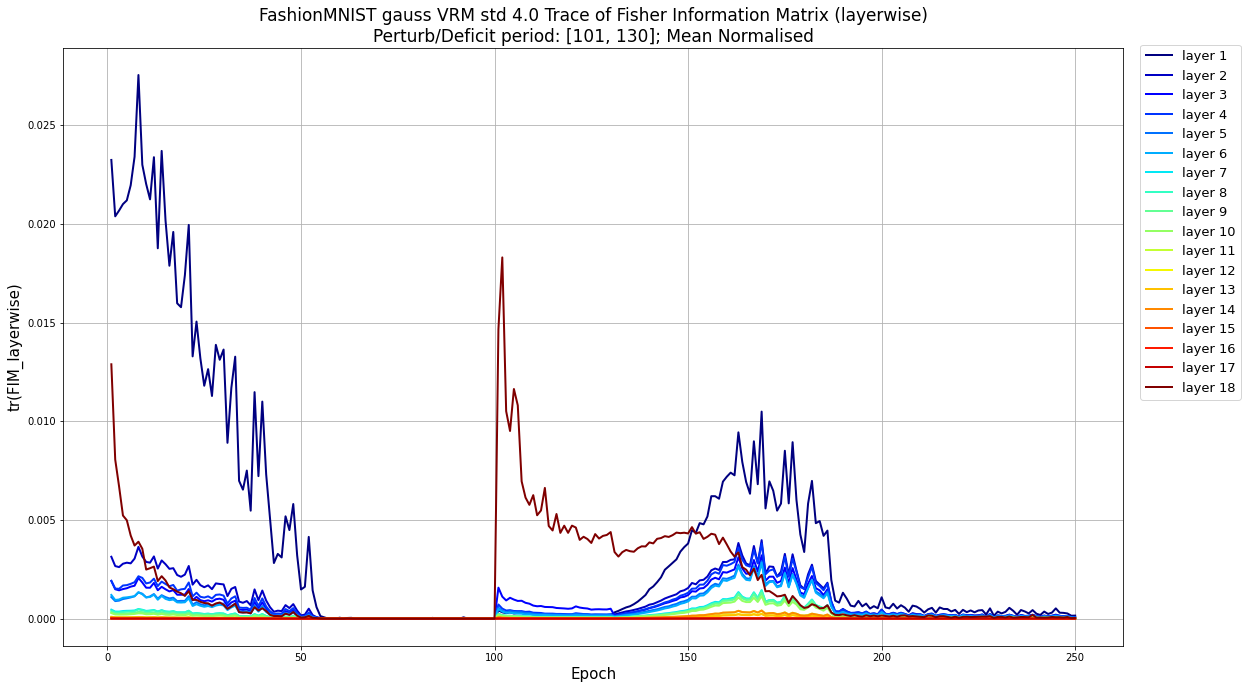

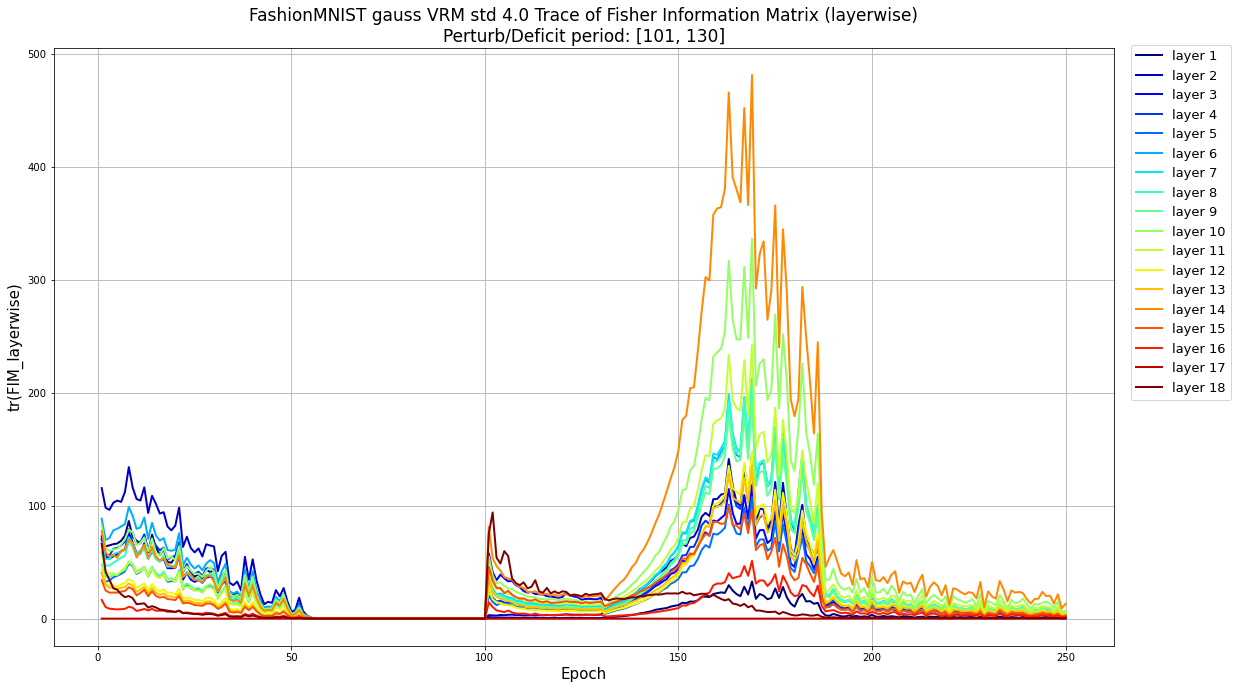

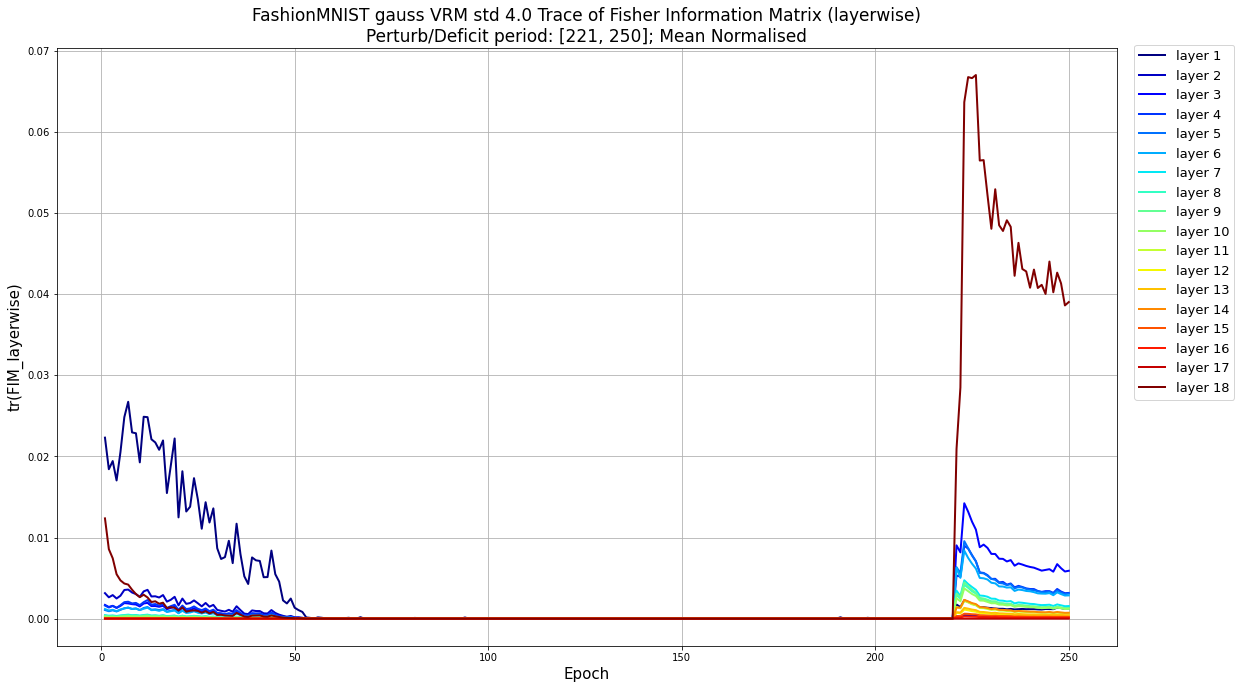

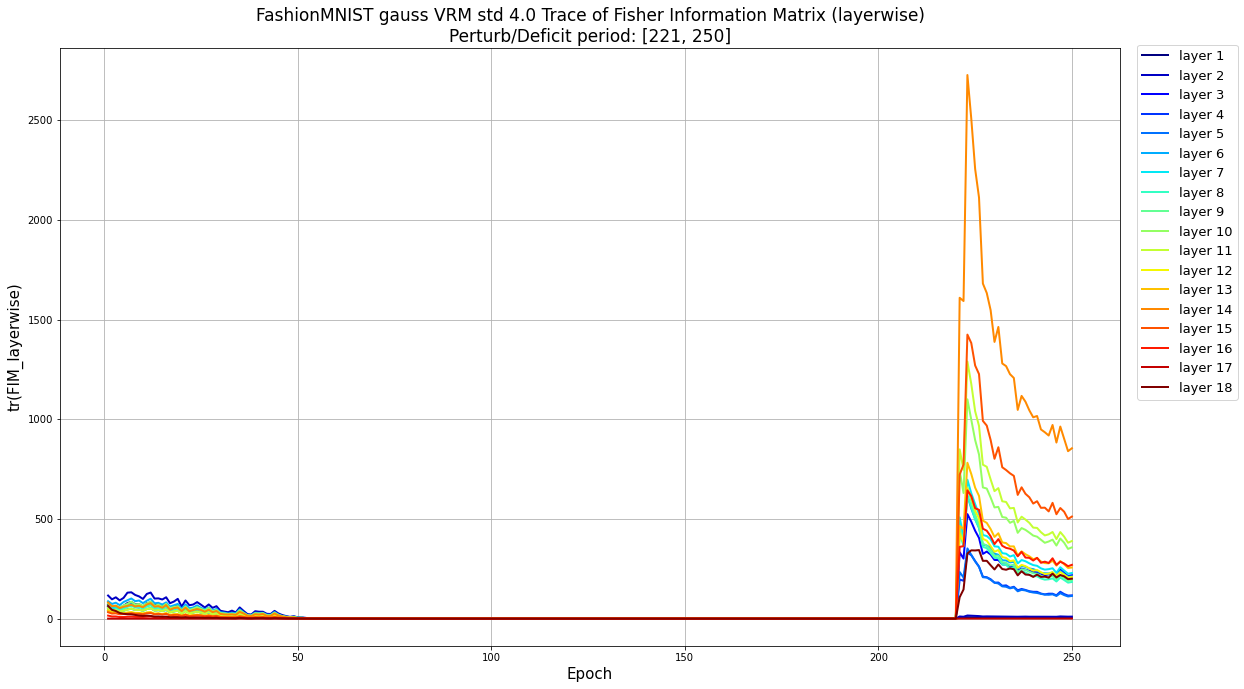

In [27]:
for i, history in enumerate(histories, 0):
    subtitle = 'Perturb/Deficit period: [{}, {}]; Mean Normalised'.format(denote[i][0], denote[i][1])
    plot_layerwise_trace_fisher(history, idx_layer, numel_layer, model, last, True, data_name, perturb_type_param, subtitle, inner_inner_savedirs[3], '{}-{}'.format(denote[i][0], denote[i][1]))
    subtitle = 'Perturb/Deficit period: [{}, {}]'.format(denote[i][0], denote[i][1])
    plot_layerwise_trace_fisher(history, idx_layer, numel_layer, model, last, False, data_name, perturb_type_param, subtitle, inner_inner_savedirs[2], '{}-{}'.format(denote[i][0], denote[i][1]))

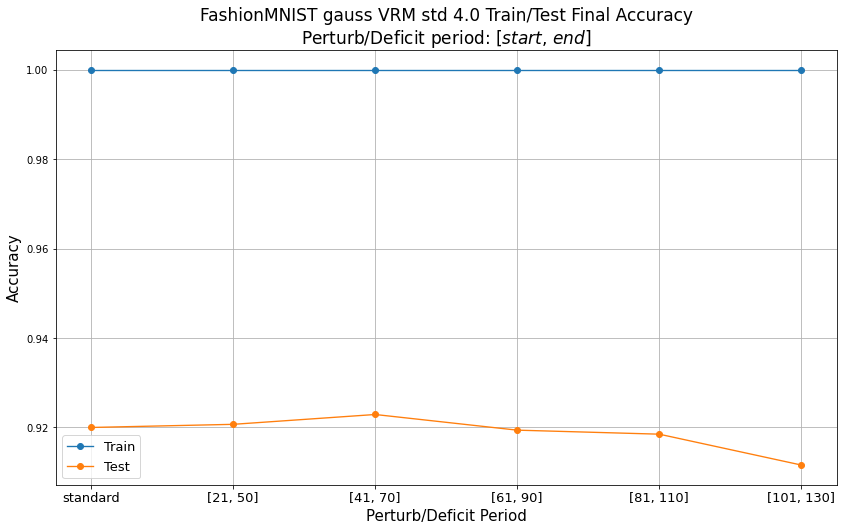

In [28]:
xticks = ['standard'] + ['[{}, {}]'.format(pt[0], pt[1]) for pt in denote]
plot_final_performance(histories, data_name, perturb_type_param, standard_history, xticks, False, inner_savedirs[1], 'final accuracy')

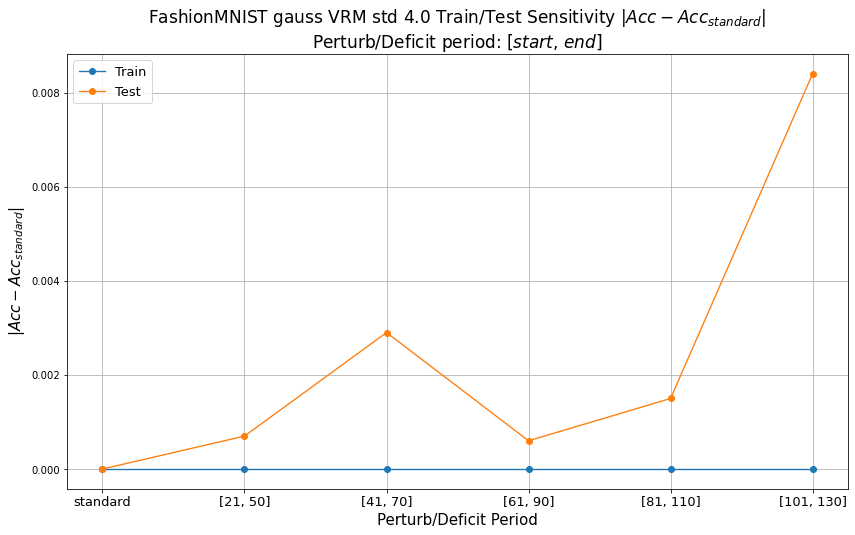

In [29]:
xticks = ['standard'] + ['[{}, {}]'.format(pt[0], pt[1]) for pt in denote]
plot_sensitive_performance(histories, data_name, perturb_type_param, standard_history, xticks, False, inner_savedirs[1], 'sensitivity')

# x-x+60 & 191-250

In [30]:
########### CHANGE

CLPs = [
    [(1, 0.0), (21, 1.0), (81, 0.0)],
    [(1, 0.0), (41, 1.0), (101, 0.0)],
    [(1, 0.0), (61, 1.0), (121, 0.0)],
    [(1, 0.0), (81, 1.0), (141, 0.0)],
    [(1, 0.0), (101, 1.0), (161, 0.0)],
    [(1, 0.0), (191, 1.0)]
]
denote = [(21, 80), (41, 100), (61, 120), (81, 140), (101, 160), (191, 250)]
temp1 = get_histories(CLPs[0:5], folder_name, small_folder_names[3])
temp2 = get_histories([CLPs[5]], folder_name, small_folder_names[4])
histories = temp1 + temp2

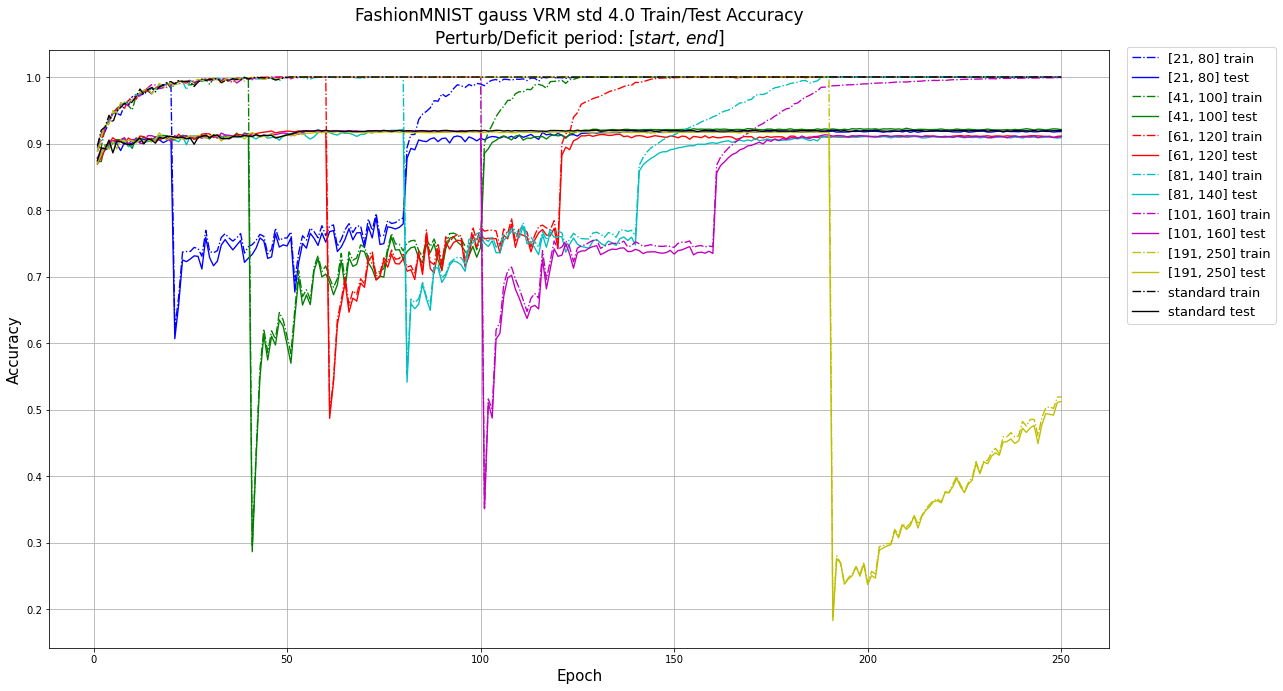

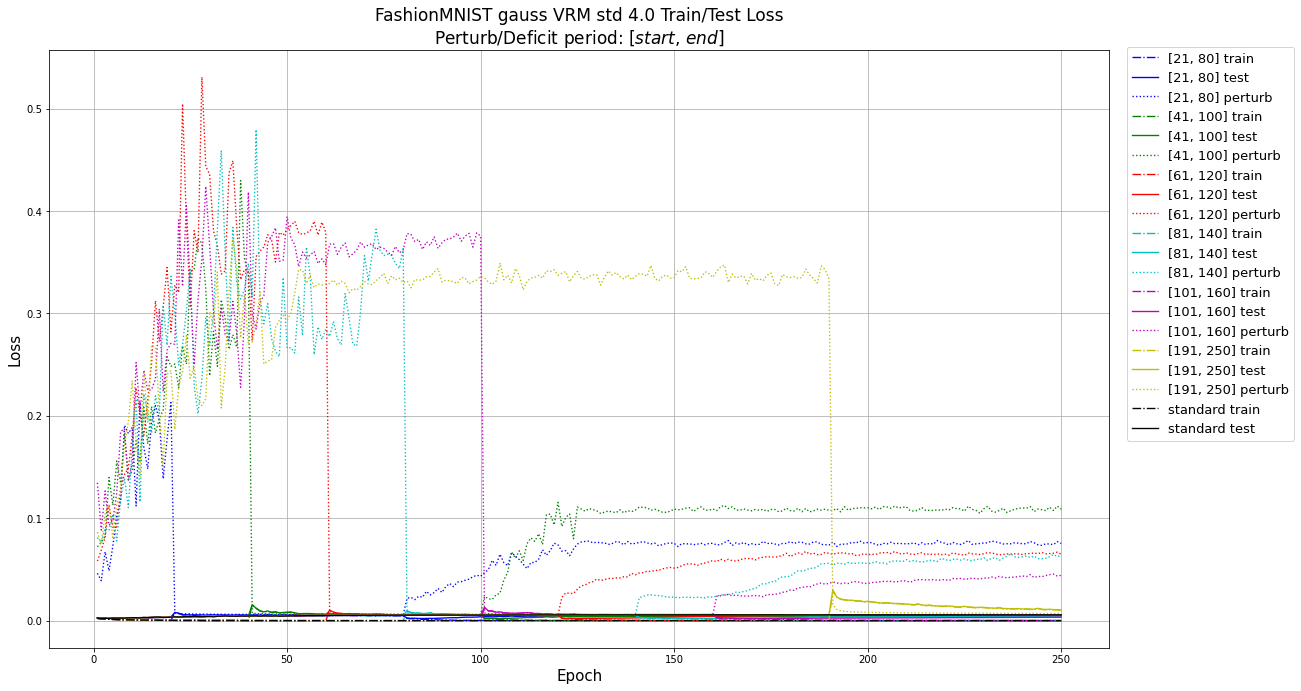

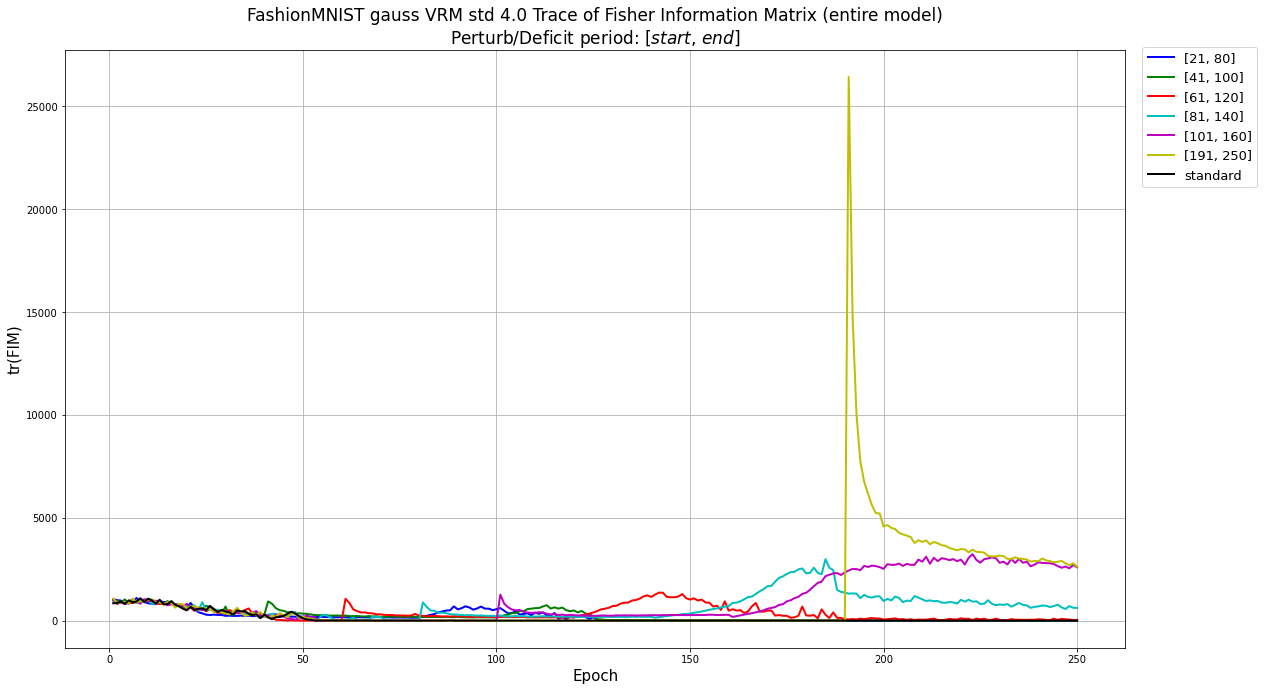

In [31]:
plot_accuracy(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[2], 'accuracy')
plot_loss(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[2], 'loss')
plot_trace_fisher_all(histories, denote, data_name, perturb_type_param, standard_history, last, inner_savedirs[2], 'total fisher')

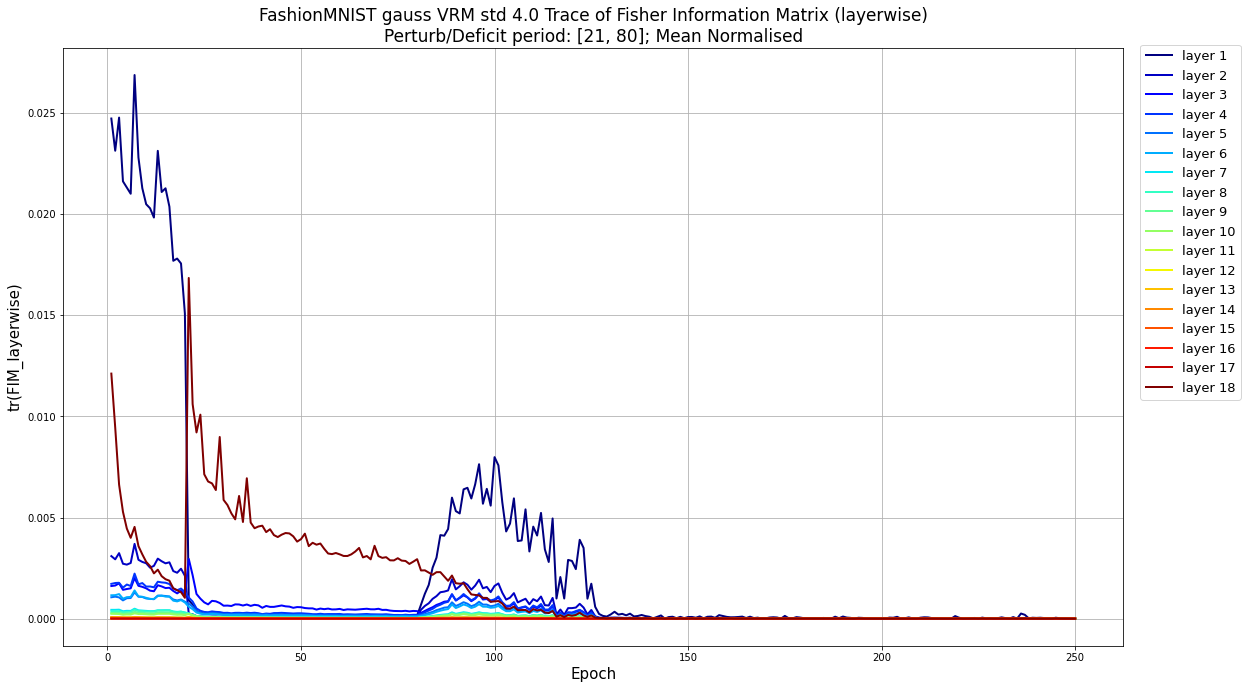

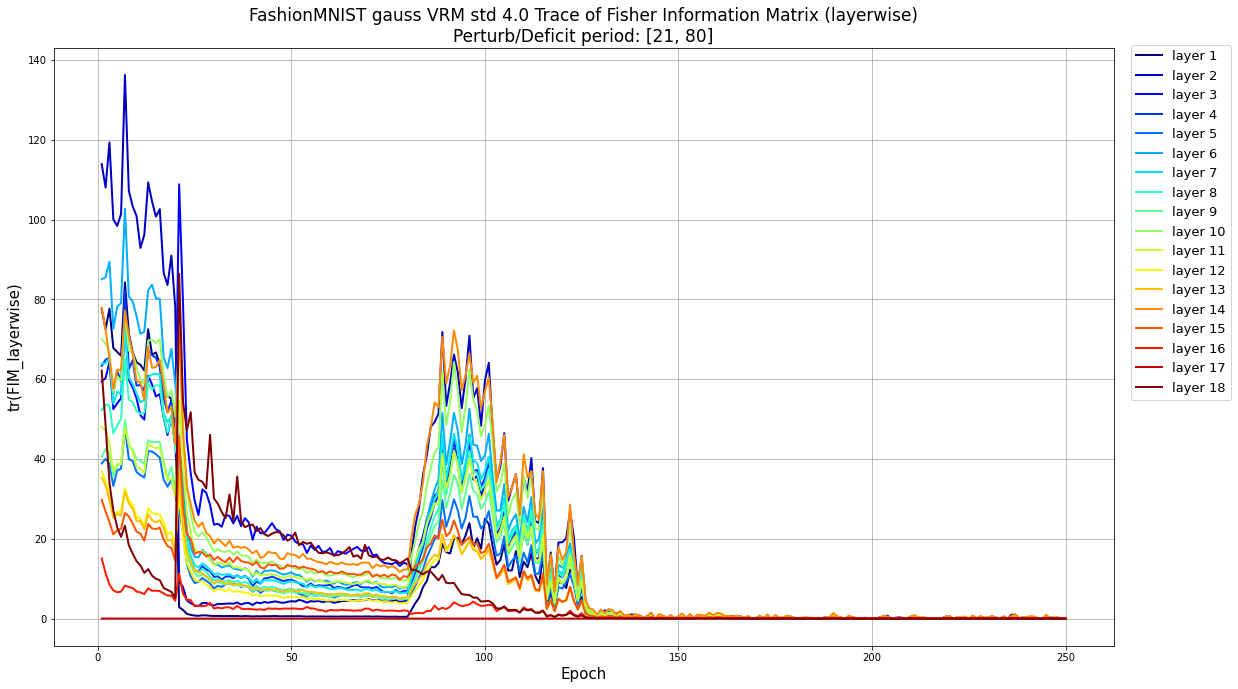

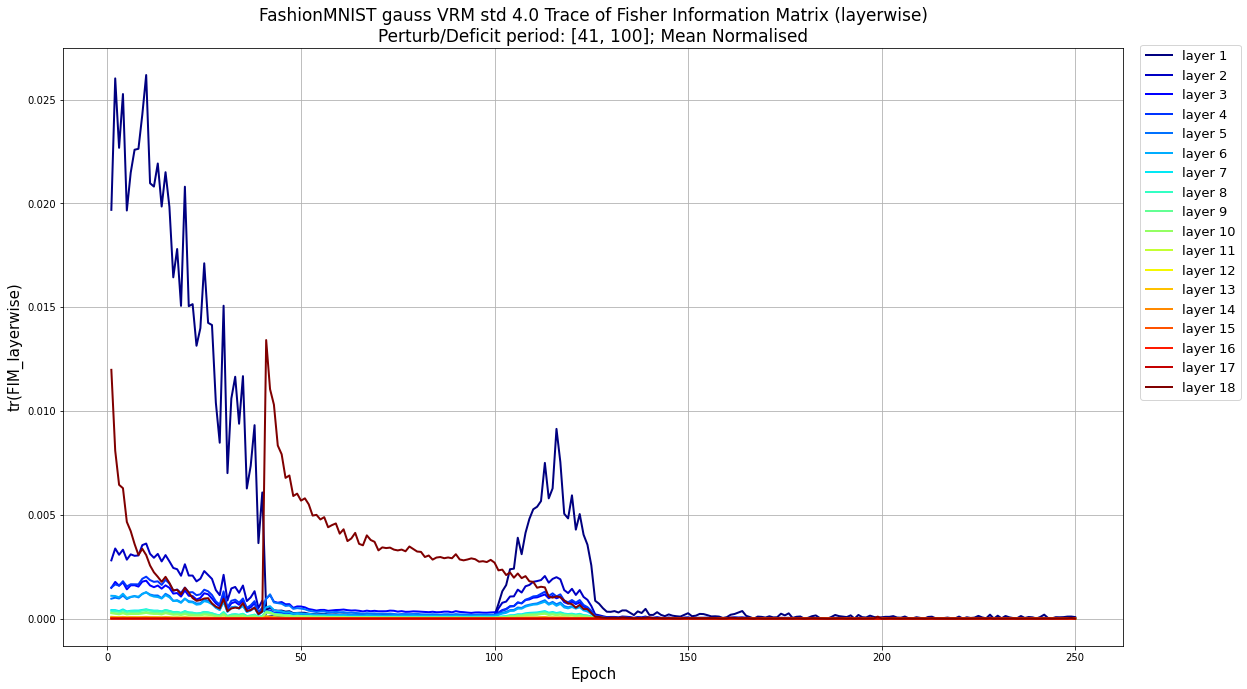

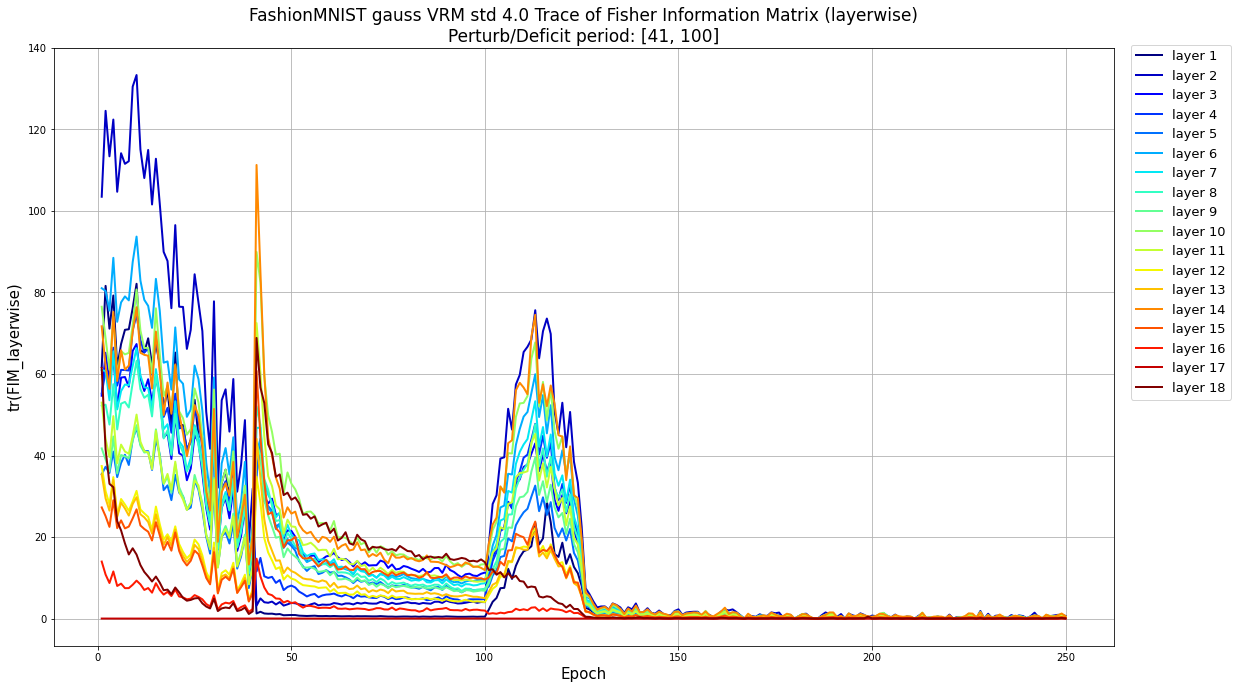

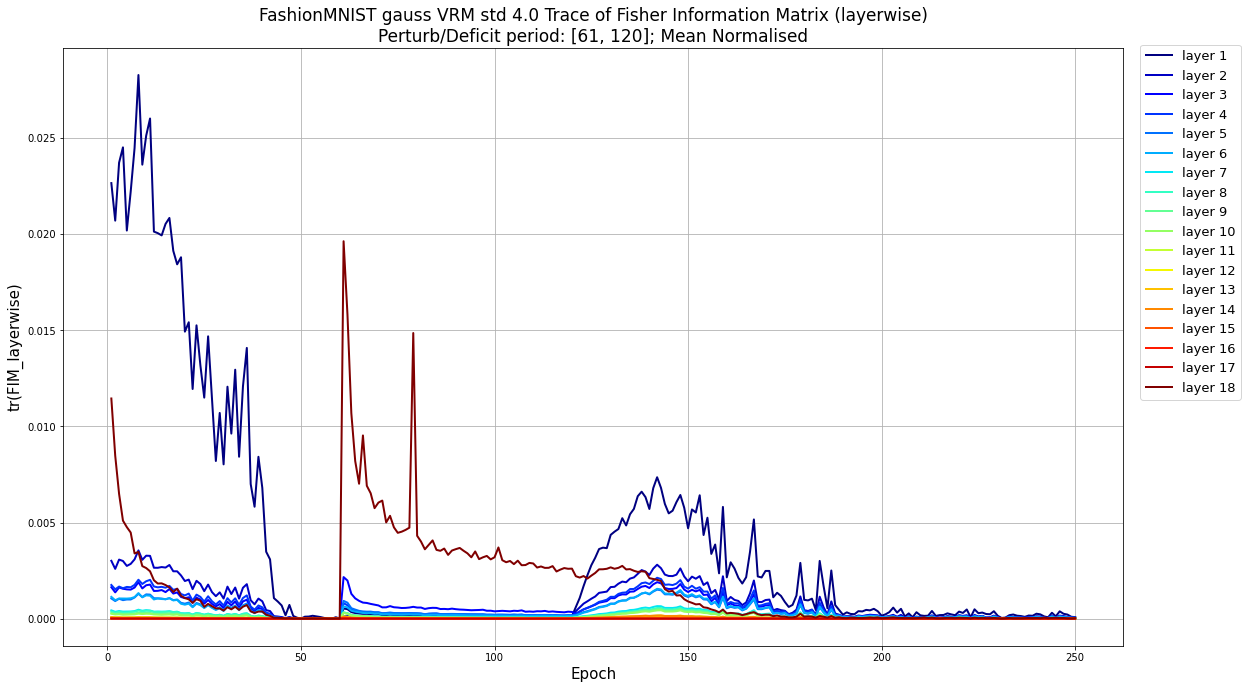

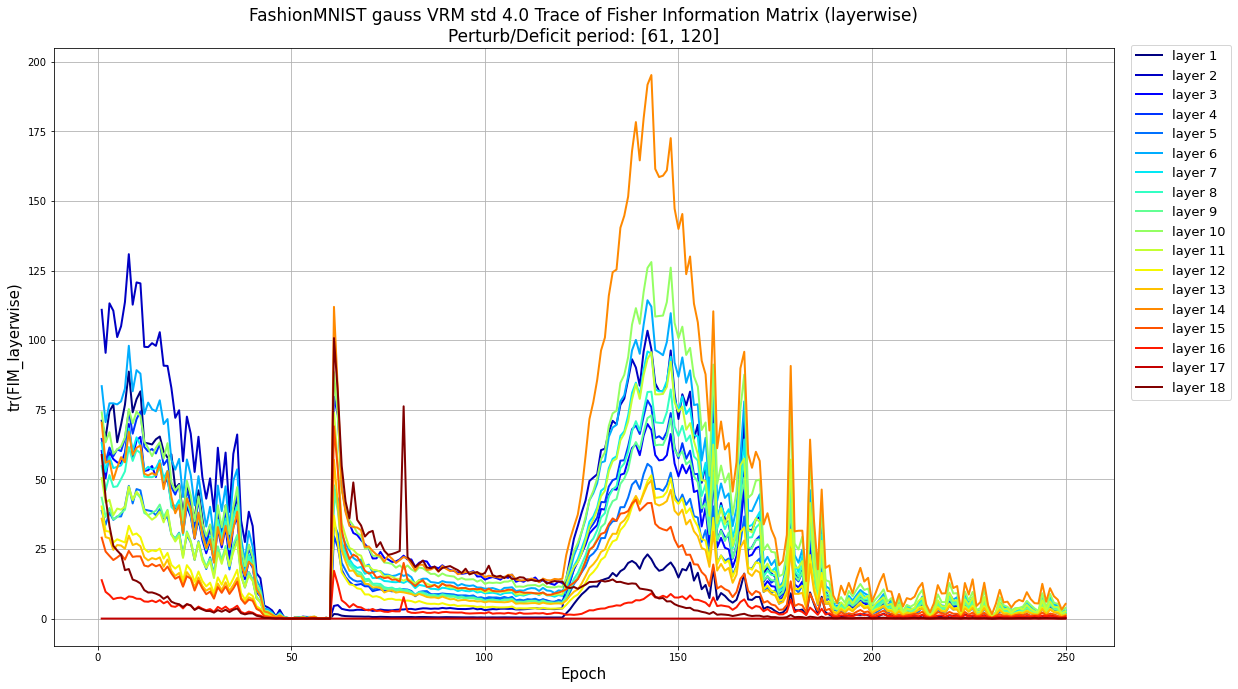

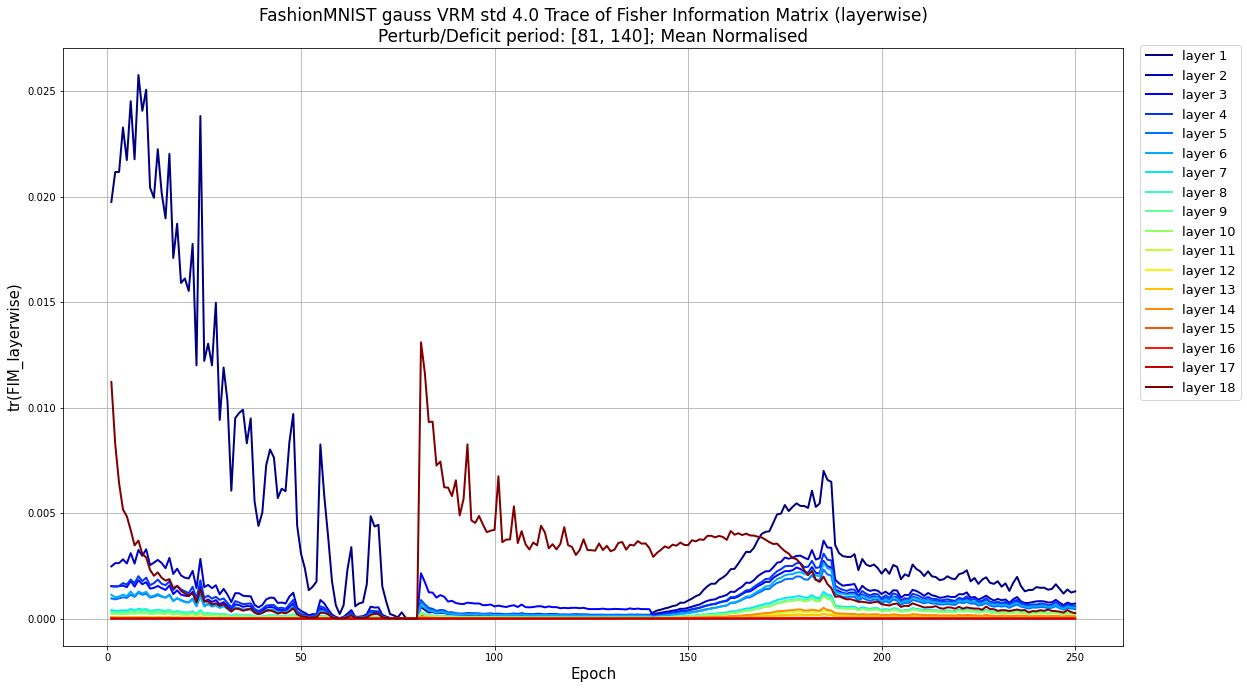

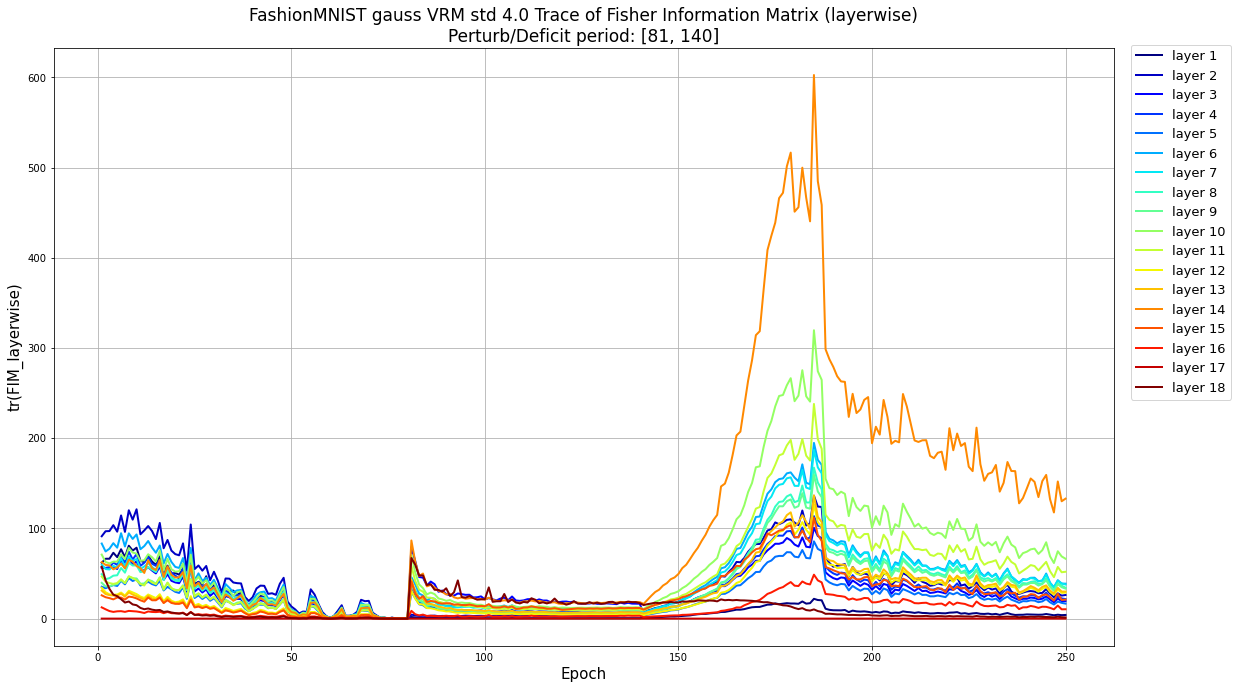

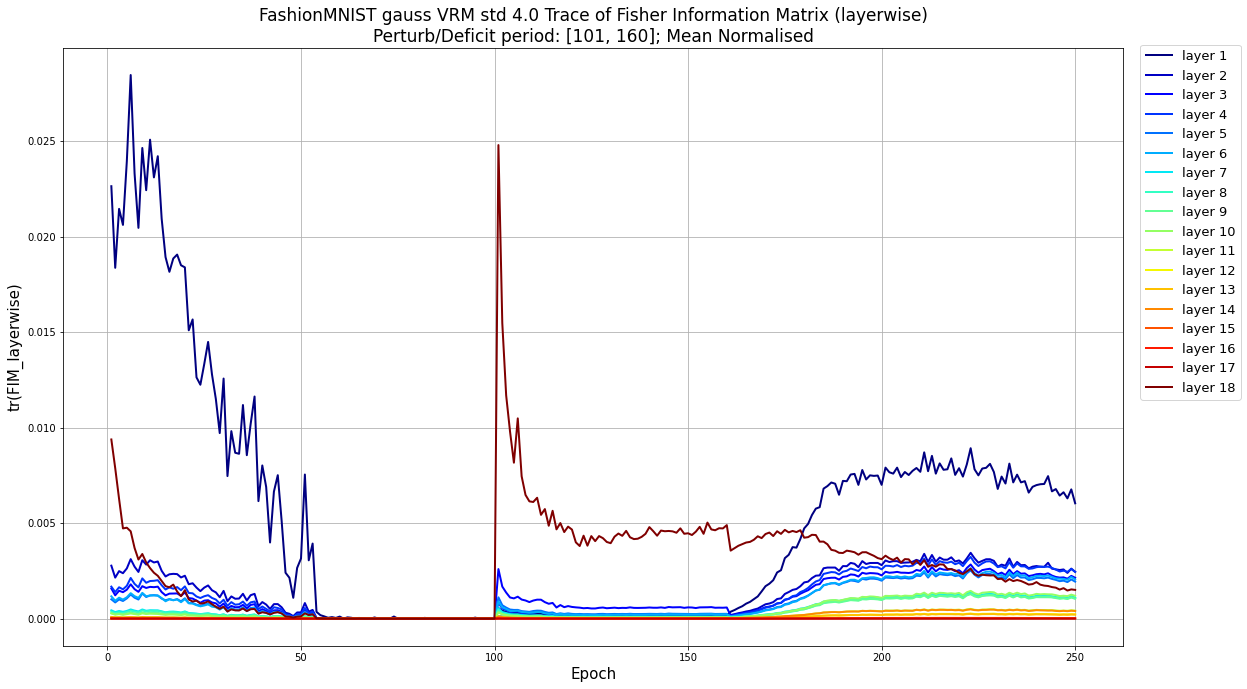

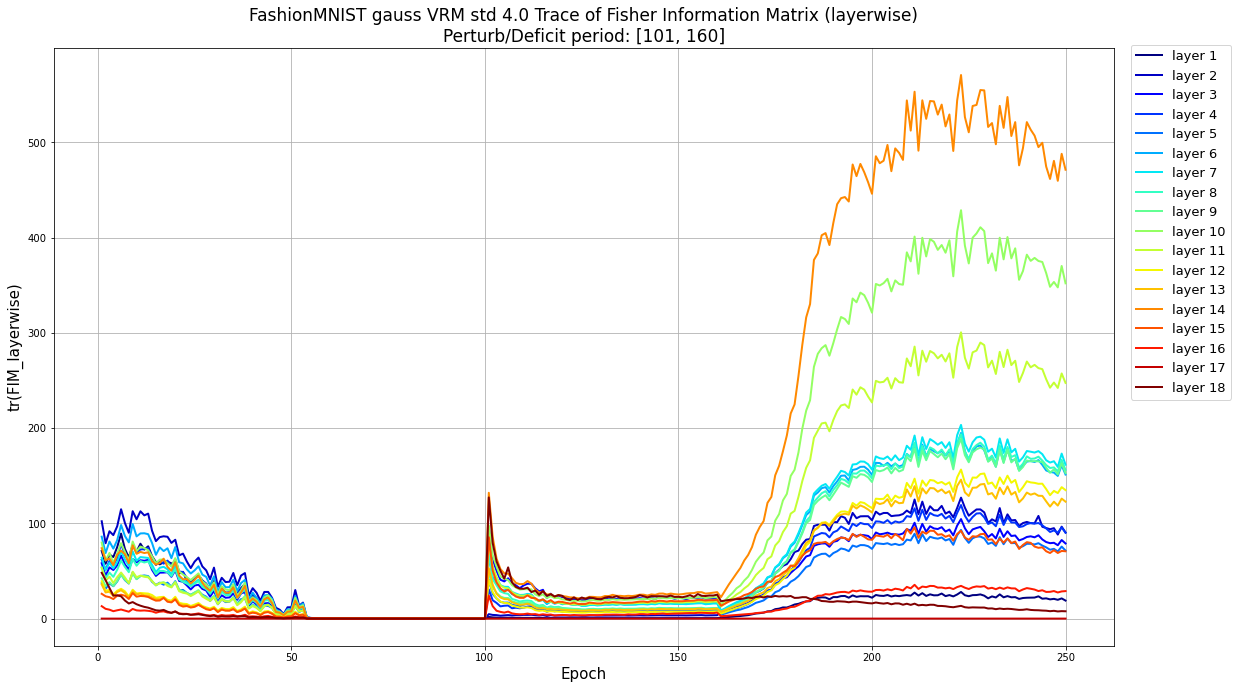

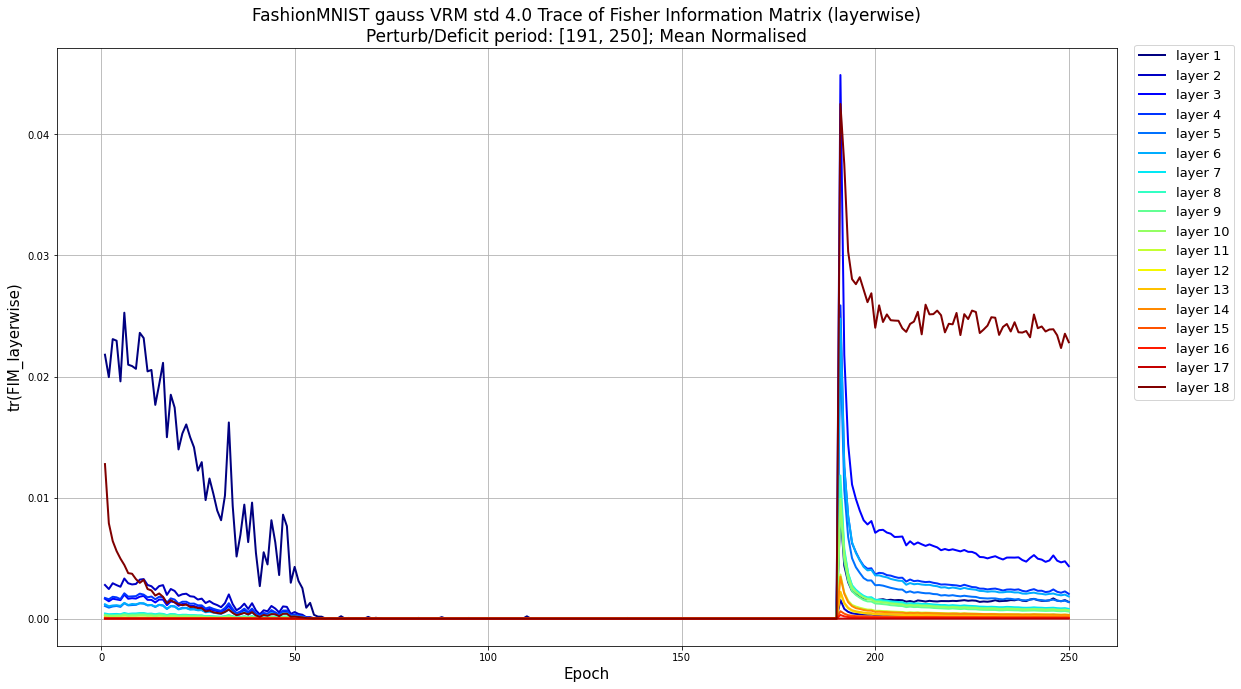

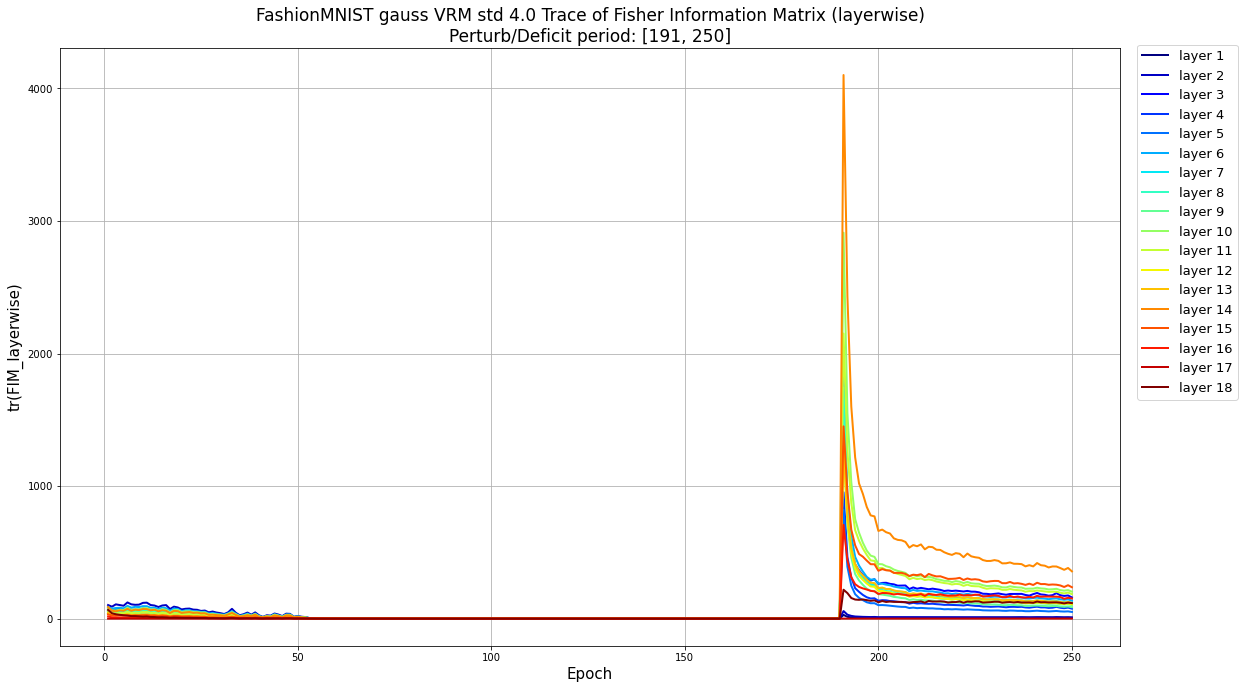

In [32]:
for i, history in enumerate(histories, 0):
    subtitle = 'Perturb/Deficit period: [{}, {}]; Mean Normalised'.format(denote[i][0], denote[i][1])
    plot_layerwise_trace_fisher(history, idx_layer, numel_layer, model, last, True, data_name, perturb_type_param, subtitle, inner_inner_savedirs[5], '{}-{}'.format(denote[i][0], denote[i][1]))
    subtitle = 'Perturb/Deficit period: [{}, {}]'.format(denote[i][0], denote[i][1])
    plot_layerwise_trace_fisher(history, idx_layer, numel_layer, model, last, False, data_name, perturb_type_param, subtitle, inner_inner_savedirs[4], '{}-{}'.format(denote[i][0], denote[i][1]))

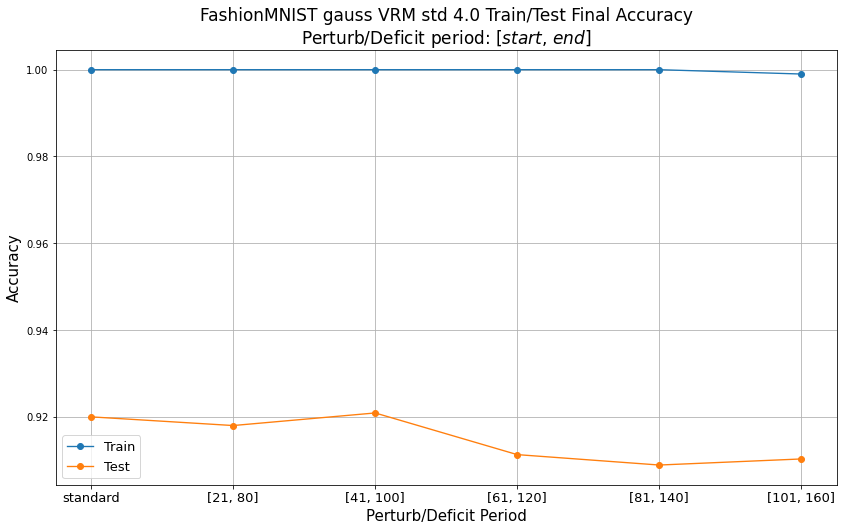

In [33]:
xticks = ['standard'] + ['[{}, {}]'.format(pt[0], pt[1]) for pt in denote]
plot_final_performance(histories, data_name, perturb_type_param, standard_history, xticks, False, inner_savedirs[2], 'final accuracy')

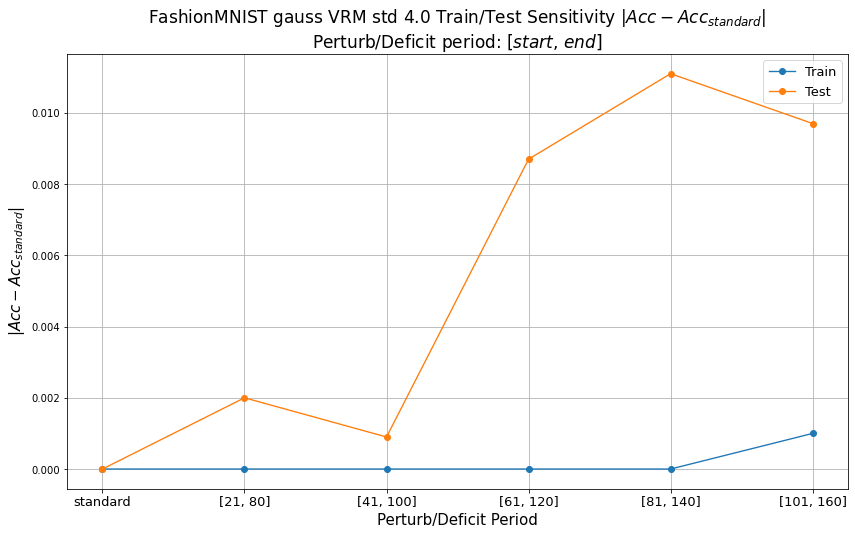

In [34]:
xticks = ['standard'] + ['[{}, {}]'.format(pt[0], pt[1]) for pt in denote]
plot_sensitive_performance(histories, data_name, perturb_type_param, standard_history, xticks, False, inner_savedirs[2], 'sensitivity')